In [1]:
import sys
sys.path.append("..")

In [2]:
# %pip install dash

In [3]:
# %pip install UMAP
# %pip install umap
# %pip install --upgrade umap-learn
# %pip install -U kaleido

In [4]:
# %pip install loguru
# %pip install numpy
# %pip install openai
# %pip install plotly

In [5]:
# %pip install nbformat==4.2.0


In [6]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances, cosine_distances
import numpy as np
import logging
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import plotly.express as px
import matplotlib.colors as mcolors
import warnings
import io
from PIL import Image
import nbformat
import IPython
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
from dch_etl.azure_clients.openai_client import OpenAiClient
import plotly.io as pio
from sklearn.metrics import pairwise
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import MinCovDet

import nbconvert


#from azure.core.credentials import AzureKeyCredential
#from azure.search.documents import SearchClient

## Importar y crear df

In [7]:
import csv

file_path = 'C:\\Users\\55641856\\Desktop\\prep-script\\cluster_centroids.csv'
with open(file_path, "r") as file:
    reader = csv.DictReader(file)
    keys = reader.fieldnames
    results = list(reader)

In [8]:
centroides_df = pd.read_csv(file_path)

# Check if the specified columns exist before selecting them
columns = ['cluster_label', 'centroid', 'etiqueta']
missing_columns = [col for col in columns if col not in centroides_df.columns]

if missing_columns:
    print(f"Warning: The following columns are missing: {missing_columns}")
else:
    centroides_df = centroides_df[columns]


In [9]:
import json

file_path = 'C:\\Users\\55641856\\Desktop\\prep-script\\documentos_pre.json'
with open(file_path, "r") as file:
    results2 = json.load(file)

In [10]:
results2[0].keys()

dict_keys(['document_path', 'ts_file_update', 'category', 'description', 'original_canonic_path', 'content_vector', 'dt_end', 'document_id', 'file_size', 'calendar_name', 'location', 'site_name', 'sp', 'title', 'sheet_name', 'event_id', 'event_name', 'dt_start', 'content', 'etiqueta_cluster', 'event_url', 'ts_creation', 'original_path', 'content_md', 'document_name', 'chunk_id', 'content_type', 'id', 'ts_processed', 'page_number', '@search.score', '@search.reranker_score', '@search.highlights', '@search.captions'])

In [11]:
embeddings_df = pd.DataFrame(results2)[['original_path', "id", "content", "content_type","category", "content_vector", 'document_id', 'chunk_id']]

Normalizar los vectores en content_vector

In [12]:
# Función para normalizar un vector
def normalizar_vector(vector):
    norma = np.linalg.norm(vector)
    return vector / norma if norma != 0 else vector

# Aplicar la normalización a cada vector en la columna content_vector
embeddings_df['content_vector_norm'] = embeddings_df['content_vector'].apply(normalizar_vector)

Asignar etiqueta a cada embedding normalizado

In [13]:
# Convertir centroides a un array de numpy, asegurando que son numéricos
centroides = np.array([np.fromstring(c[1:-1], sep=',') for c in centroides_df['centroid'].values])

# # Verifica las dimensiones
# print("Dimensiones de los embeddings:", embeddings_df['content_vector_norm'].iloc[0].shape)
# print("Dimensiones de los centroides:", centroides.shape)

# Función para calcular la distancia Euclidiana
def calcular_distancia(embedding, centroides):
    return np.linalg.norm(centroides - embedding, axis=1)

# Listas para almacenar las etiquetas y los centroides más cercanos
etiquetas_cercanas = []
centroides_cercanos = []

# Iterar sobre cada embedding en embeddings_df
for index, row in embeddings_df.iterrows():
    embedding = row['content_vector_norm']
    distancias = calcular_distancia(embedding, centroides)
    indice_minimo = np.argmin(distancias)
    
    # Agregar la etiqueta y el centroide correspondiente al DataFrame
    etiquetas_cercanas.append(centroides_df['etiqueta'].iloc[indice_minimo])
    centroides_cercanos.append(centroides[indice_minimo])

# Crear nuevas columnas en embeddings_df
embeddings_df['etiqueta_asignada'] = etiquetas_cercanas
embeddings_df['centroide'] = centroides_cercanos



# I) Análisis en función del content type

In [19]:
# Count the quantity of chunk_id per content_type
chunk_count_per_type = embeddings_df.groupby('content_type')['chunk_id'].count().reset_index()

# Rename the columns for clarity
chunk_count_per_type.columns = ['content_type', 'chunk_count']
print(chunk_count_per_type)


  content_type  chunk_count
0         aspx         2277
1          doc            1
2         docx           22
3         html            3
4          jpg            6
5          odt            1
6          pdf         3309
7          png            8
8         pptx           54
9         xlsx           74


In [129]:
def chunks_per_content():
    # Count the quantity of chunks per content type
    chunk_count_per_type = embeddings_df.groupby('content_type')['chunk_id'].count().reset_index()
    chunk_count_per_type.columns = ['content_type', 'chunk_count']

    # Sort the chunk count in descending order
    chunk_count_per_type_sorted = chunk_count_per_type.sort_values(by='chunk_count', ascending=False)

    # Create the bar plot
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x='content_type', y='chunk_count', data=chunk_count_per_type_sorted, palette='viridis')

    # Set the Y-axis to a logarithmic scale
    ax.set(yscale="log")

    # Add numeric annotations on each bar
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:,.0f}',  # format the number with commas and no decimals
                    (p.get_x() + p.get_width() / 2., height),  # x position at the center of the bar
                    ha='center', va='center',  # center the label horizontally and vertically
                    fontsize=10, color='black',  # font size and color
                    xytext=(0, 5), textcoords='offset points')  # offset the label a bit upwards

    # Title and labels
    ax.set_title('Número total de chunks en función del tipo (campo: content_type)')
    ax.set_xlabel('Tipo de contenido')
    ax.set_ylabel('Número de chunks en escala logarítmica')
    
    # Return the figure
    fig = ax.get_figure()
    # Uncomment to display the plot
    # plt.show()

    return fig



El gráfico muestra el número total de chunks en función del tipo de contenido (campo: content_type) en una escala logarítmica. A continuación, se destacan las principales tendencias y conclusiones:

1. **PDF y ASPX**: Los tipos de contenido PDF y ASPX tienen, con diferencia, el mayor número de chunks, con 3,309 y 2,277 respectivamente. Esto indica que estos formatos son los más fragmentados o los más utilizados en el conjunto de datos.

2. **Otros formatos de documentos**: Los formatos XLSX y PPTX también tienen un número significativo de chunks, con 74 y 54 respectivamente, aunque mucho menor en comparación con PDF y ASPX.

3. **Formatos de imagen y HTML**: Los formatos de imagen (PNG y JPG) y HTML tienen un número menor de chunks, con 8, 6 y 3 respectivamente.

4. **DOC y ODT**: Los formatos DOC y ODT tienen el menor número de chunks, con solo 1 cada uno.

En resumen, el gráfico muestra una clara predominancia de los formatos PDF y ASPX en términos de número de chunks, seguidos por X

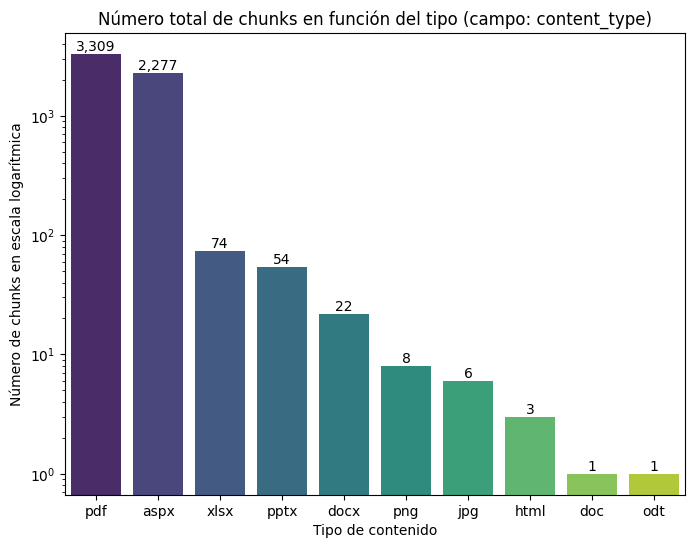

In [27]:
warnings.filterwarnings("ignore")
fig=chunks_per_content()
fig_array = fig_to_image(fig)
interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)

# The result is the interpretation text from the model
print(interpretation)

In [29]:
def doc_count():
    doc_count_per_type = embeddings_df.groupby('content_type')['document_id'].nunique().reset_index()
    doc_count_per_type.columns = ['content_type', 'doc_count']

    # Sort by doc_count in descending order
    doc_count_per_type = doc_count_per_type.sort_values(by='doc_count', ascending=False)

    # Create the bar plot with seaborn
    fig, ax = plt.subplots(figsize=(10, 6))  # Create the figure and axes

    # Create the bar plot
    sns.barplot(x='content_type', y='doc_count', data=doc_count_per_type, palette='viridis', ax=ax)

    # Set the y-axis to logarithmic scale
    ax.set(yscale='log')

    # Add numeric annotations on each bar
    for p in ax.patches:
        height = p.get_height()  # Get the height of each bar
        ax.annotate(f'{height:,.0f}',  # Format the number
                    (p.get_x() + p.get_width() / 2., height),  # x position at the center of the bar, y position at the top of the bar
                    ha='center', va='center',  # Center the label horizontally and vertically
                    fontsize=10, color='black',  # Font size and color
                    xytext=(0, 5), textcoords='offset points')  # Offset the label slightly upwards

    # Set titles and labels
    ax.set_title('Número total de documentos en función del tipo (campo: content_type)')
    ax.set_xlabel('Tipo de contenido')
    ax.set_ylabel('Número de documentos en escala logarítmica')

    # Rotate x-axis labels if needed (especially useful for long content_type labels)
    plt.xticks(rotation=45, ha='right')

    # Adjust layout to make sure everything fits
    plt.tight_layout()

    # Return the figure
    return fig


El gráfico muestra el número total de documentos en función del tipo de contenido, utilizando una escala logarítmica para el eje y. A continuación, se destacan las principales tendencias y conclusiones:

1. **Predominio de PDFs y ASPX**: Los documentos de tipo PDF son los más numerosos, con un total de 705, seguidos por los documentos de tipo ASPX con 427. Estos dos tipos de documentos son significativamente más comunes que los demás.

2. **Documentos de tipo DOCX y XLSX**: Los documentos de tipo DOCX (22) y XLSX (11) también son relativamente comunes, aunque en menor cantidad comparados con los PDFs y ASPX.

3. **Menor cantidad de otros tipos de documentos**: Los documentos de tipo PNG (8), PPTX (7), JPG (5) y HTML (3) tienen una presencia mucho menor.

4. **Tipos de documentos menos comunes**: Los documentos de tipo DOC y ODT son los menos comunes, con solo 1 documento cada uno.

En resumen, los documentos de tipo PDF y ASPX dominan claramente en número, mientras que otros tipos de d

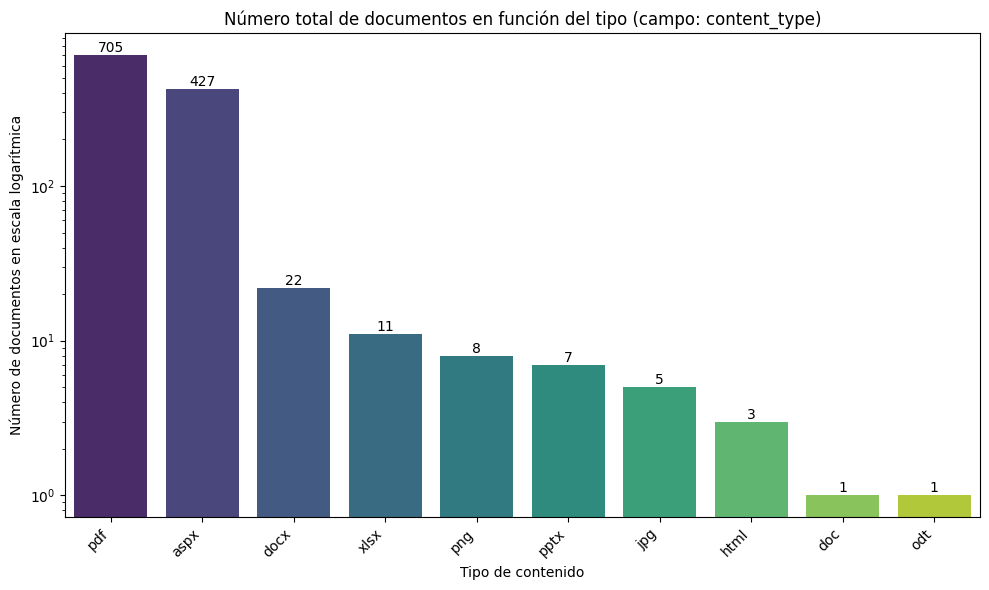

In [30]:
warnings.filterwarnings("ignore")
fig=doc_count()
fig_array = fig_to_image(fig)
interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)
print(interpretation)

In [20]:
def chunk_doc_relation():
    # Count the quantity of chunks per content type
    chunk_count_per_type = embeddings_df.groupby('content_type')['chunk_id'].count().reset_index()
    chunk_count_per_type.columns = ['content_type', 'chunk_count']

    # Count the quantity of unique document_id per content_type
    doc_count_per_type = embeddings_df.groupby('content_type')['document_id'].nunique().reset_index()
    doc_count_per_type.columns = ['content_type', 'doc_count']

    # Merge the two DataFrames on content_type
    merged_counts = pd.merge(chunk_count_per_type, doc_count_per_type, on='content_type')

    # Calculate the ratio of chunk_count to doc_count
    merged_counts['ratio'] = merged_counts['chunk_count'] / merged_counts['doc_count']

    # Calculate standard deviation of chunks per document for each content_type
    chunk_std_per_type = embeddings_df.groupby('content_type').apply(
        lambda x: (x.groupby('document_id')['chunk_id'].count().mean(), 
                  x.groupby('document_id')['chunk_id'].count().std())
    ).reset_index(name='mean_chunks', level=0)

    # Merge mean and std back to merged_counts
    merged_counts = pd.merge(merged_counts, chunk_std_per_type, on='content_type')

    # Sort by ratio in descending order
    merged_counts = merged_counts.sort_values(by='ratio', ascending=False)

    # Create the bar plot with seaborn
    fig, ax = plt.subplots(figsize=(12, 6))  # Create a figure object
    sns.barplot(x='content_type', y='mean_chunks', data=merged_counts, palette='viridis', ax=ax)

    # Add stripes for the std (error bars)
    ax.errorbar(x=range(len(merged_counts)), 
                y=merged_counts['mean_chunks'], 
                yerr=merged_counts['std_chunks'], 
                fmt='none', ecolor='red', elinewidth=2, capsize=5)

    # Set y-axis to log scale
    ax.set(yscale='log')

    # Add text annotations with mean values
    for i in range(len(merged_counts)):
        ax.text(i, merged_counts['mean_chunks'].iloc[i], 
                f"{round(merged_counts['mean_chunks'].iloc[i], 2)}", 
                ha='center', va='bottom', fontsize=10)

    # Set title and labels
    ax.set_title('Number of Chunks per Document by Content Type')
    ax.set_xlabel('Content Type')
    ax.set_ylabel('Mean Number of Chunks per Document')

    # Adjust layout for better readability
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Return both the figure and the ratio values
    return plt.gcf()


TypeError: Invalid object type at position 0

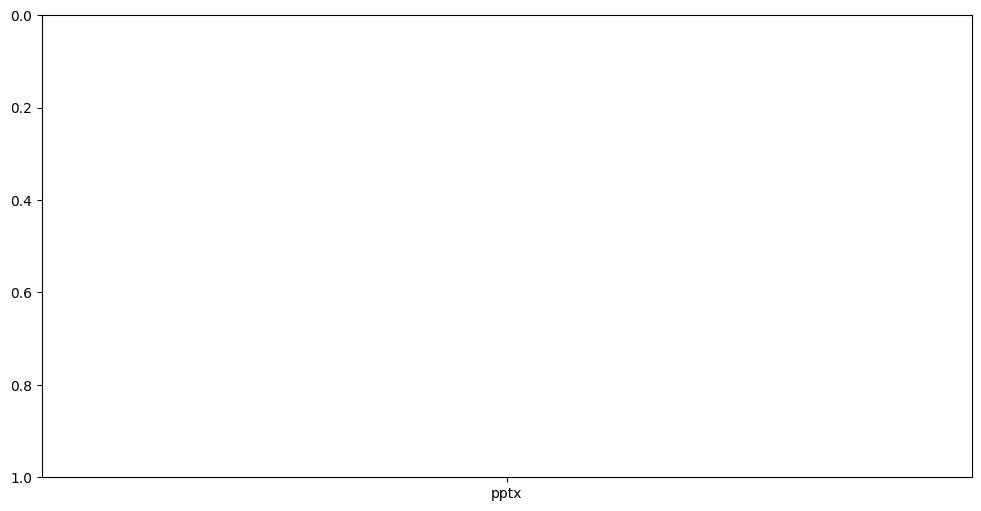

In [21]:
warnings.filterwarnings("ignore")
fig=chunk_doc_relation()
fig_array = fig_to_image(fig)
interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)
print(interpretation)

# II) Análisis en función de category

Asignamos un color a cada tipo de chunk

In [20]:
color_mapping = {
    'site': '#FFB347',
    'calendar': '#84b6f4',  
    'table': '#77dd77',    
    'document': '#ff6961',      
}
embeddings_df['color'] = embeddings_df['category'].map(color_mapping)

In [ ]:
def chunks_per_category():
    # Count the quantity of chunks per category, including color
    chunk_count_per_type = embeddings_df.groupby(['category', 'color'])['chunk_id'].count().reset_index()
    chunk_count_per_type.columns = ['category', 'color', 'chunk_count']

    # Sort by 'chunk_count' in descending order
    chunk_count_per_type = chunk_count_per_type.sort_values(by='chunk_count', ascending=False)

    # Create a dictionary for the palette that maps each category to its color
    category_colors = dict(zip(chunk_count_per_type['category'], chunk_count_per_type['color']))

    # Create the bar plot with Seaborn using the custom color palette
    plt.figure(figsize=(10, 6))  # Set figure size
    ax = sns.barplot(x='category', y='chunk_count', data=chunk_count_per_type, palette=category_colors)

    # Set the Y-axis to a logarithmic scale
    ax.set(yscale='log')

    # Add numeric values on each bar
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',  # The value on top of each bar
                    (p.get_x() + p.get_width() / 2., p.get_height()),  # Coordinates (position)
                    ha='center', va='center',  # Alignment
                    fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

    # Add title and labels
    ax.set_title('Número total de chunks por Categoría (category)')
    ax.set_xlabel('Categorías')
    ax.set_ylabel('Número de chunks en escala logarítmica')

    # Rotate X-axis labels if necessary
    plt.xticks(rotation=45, ha='right')

    # Adjust layout to avoid overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Return the figure if further modification or saving is needed
    return ax.figure


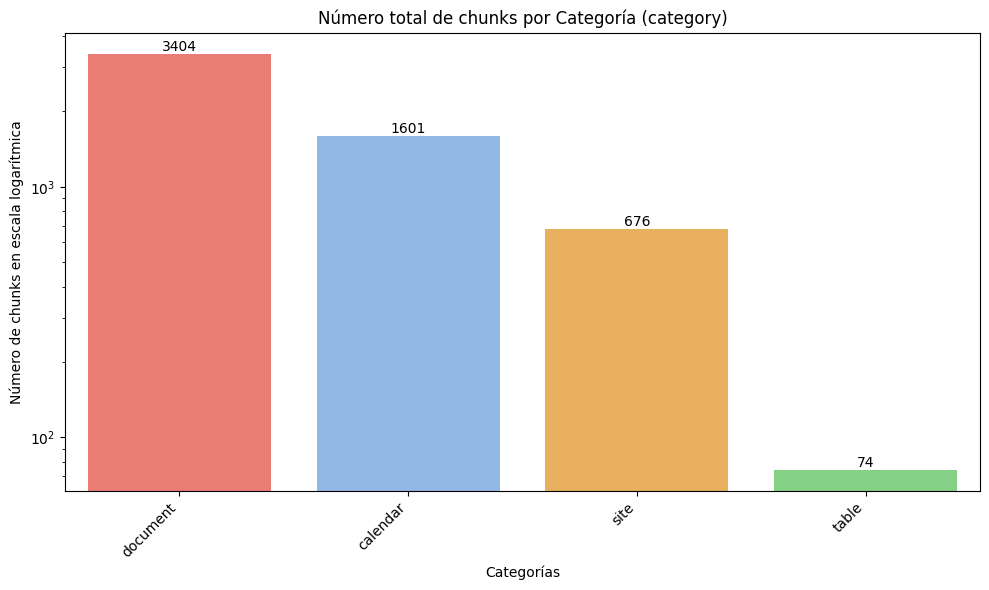

El gráfico muestra el número total de "chunks" por categoría en una escala logarítmica. Las categorías representadas son "document", "calendar", "site" y "table". 

Las principales tendencias y conclusiones son las siguientes:

1. **Document**: Es la categoría con el mayor número de chunks, con un total de 3404.
2. **Calendar**: Ocupa el segundo lugar con 1601 chunks.
3. **Site**: Tiene 676 chunks, situándose en el tercer lugar.
4. **Table**: Es la categoría con el menor número de chunks, con solo 74.

La diferencia entre las categorías es significativa, especialmente entre "document" y "table", lo que indica una distribución desigual del número de chunks entre las diferentes categorías.


In [24]:
warnings.filterwarnings("ignore")
fig=chunks_per_category()
fig_array = fig_to_image(fig)
interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)
print(interpretation)

In [32]:
def plot_chunks_per_doc_ratio():
    # Count the quantity of 'chunk_id' per 'category'
    chunk_count_per_type = embeddings_df.groupby('category')['chunk_id'].count().reset_index()
    chunk_count_per_type.columns = ['category', 'chunk_count']

    # Count the quantity of unique 'document_id' per 'category'
    doc_count_per_type = embeddings_df.groupby('category')['document_id'].nunique().reset_index()
    doc_count_per_type.columns = ['category', 'doc_count']

    # Merge the two DataFrames on 'category'
    merged_counts = pd.merge(chunk_count_per_type, doc_count_per_type, on='category')

    # Calculate the ratio of chunk_count to doc_count
    merged_counts['ratio'] = merged_counts['chunk_count'] / merged_counts['doc_count']

    # Sort by ratio in descending order
    merged_counts = merged_counts.sort_values(by='ratio', ascending=False)

    # Create a color map based on the 'color' column in embeddings_df
    unique_categories = merged_counts['category'].unique()
    color_mapping = {category: color for category, color in zip(embeddings_df['category'], embeddings_df['color']) if category in unique_categories}

    # Create a bar plot
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='category', y='ratio', data=merged_counts, palette=color_mapping)

    # Set the Y-axis to a logarithmic scale
    ax.set(yscale='log')

    # Add text annotations for 'chunk_count' and 'doc_count'
    for i, row in merged_counts.iterrows():
        ax.text(i, row['ratio'], f"{round(row['ratio'],1)}", ha='center', va='bottom', fontsize=9)

    # Set titles and labels
    ax.set_title('Ratio of Chunks per Document by Category')
    ax.set_xlabel('Category')
    ax.set_ylabel('Ratio of Chunk Count to Document Count (log scale)')

    # Adjust layout to avoid overlap
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    return fig


El gráfico muestra el número total de chunks en función del tipo de contenido (campo: content_type) en una escala logarítmica. A continuación, se destacan las principales tendencias y conclusiones:

1. **PDF y ASPX**: Los tipos de contenido PDF y ASPX tienen, con diferencia, el mayor número de chunks, con 3,309 y 2,277 respectivamente. Esto sugiere que estos formatos son los más fragmentados o los más utilizados en el conjunto de datos.

2. **Otros formatos de documentos**: Los formatos XLSX y PPTX también tienen un número significativo de chunks, con 74 y 54 respectivamente, aunque mucho menor en comparación con PDF y ASPX.

3. **Formatos de imagen y HTML**: Los formatos de imagen (PNG y JPG) y HTML tienen un número considerablemente menor de chunks, con 8, 6 y 3 respectivamente.

4. **DOC y ODT**: Los formatos DOC y ODT tienen el menor número de chunks, con solo 1 cada uno, lo que indica una baja fragmentación o uso en el conjunto de datos.

En resumen, el gráfico muestra una clara p

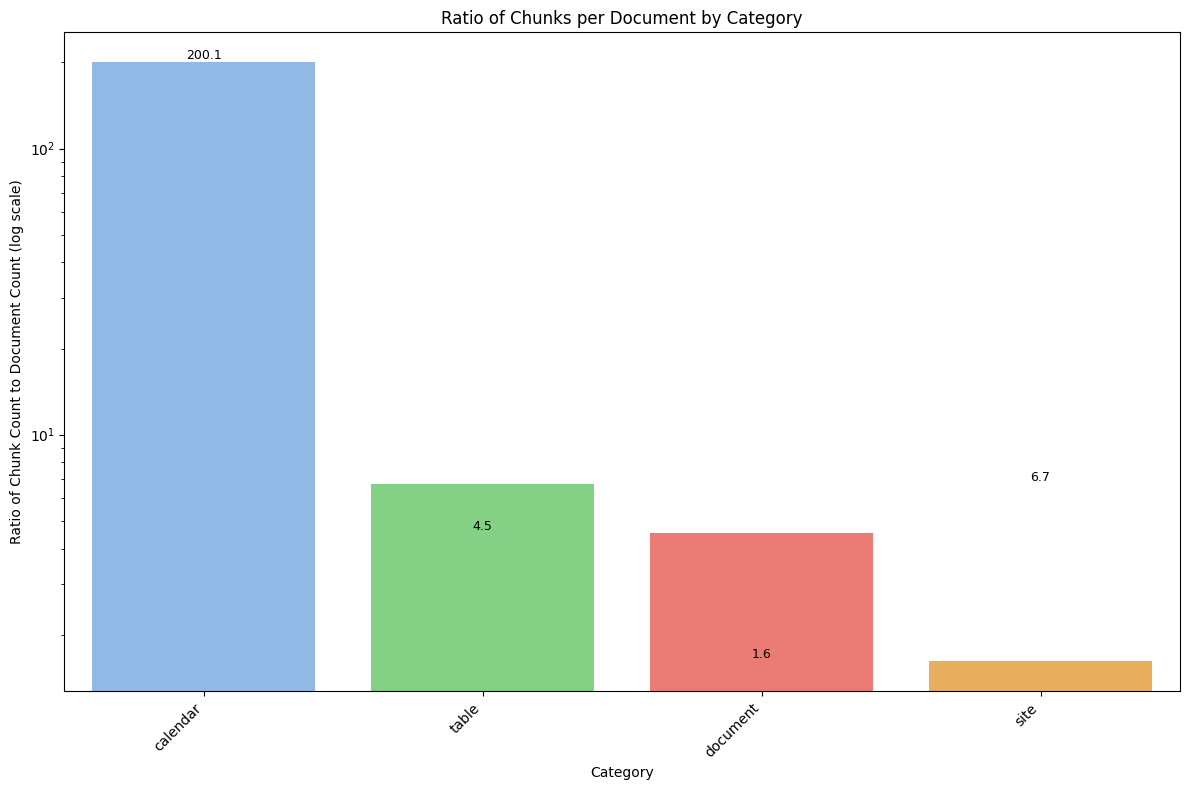

In [33]:
warnings.filterwarnings("ignore")
fig=plot_chunks_per_doc_ratio()
fig_array = fig_to_image(fig)
interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)
print(interpretation)

In [42]:
def plot_chunks_per_doc_id():
    # Count the quantity of 'chunk_id' per 'document_id' within each 'category'
    chunk_count_per_doc = embeddings_df.groupby(['category', 'document_id'])['chunk_id'].count().reset_index()
    chunk_count_per_doc.columns = ['category', 'document_id', 'chunk_count']
    
    # Now, aggregate by 'category' to get the average and standard deviation of chunk counts per document
    stats_per_category = chunk_count_per_doc.groupby('category')['chunk_count'].agg(['mean', 'std']).reset_index()
    stats_per_category.columns = ['category', 'avg_chunk_count_per_doc', 'std_chunk_count_per_doc']
    
    # Sort by 'avg_chunk_count_per_doc' in descending order
    stats_per_category = stats_per_category.sort_values(by='avg_chunk_count_per_doc', ascending=False)
    
    # Create a color map based on the 'color' column in embeddings_df
    unique_categories = stats_per_category['category'].unique()
    color_mapping = {category: color for category, color in zip(embeddings_df['category'], embeddings_df['color']) if category in unique_categories}

    # Create a bar plot
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='category', y='avg_chunk_count_per_doc', data=stats_per_category, palette=color_mapping)

    for i, row in stats_per_category.iterrows():
        category = row['category']
        avg = row['avg_chunk_count_per_doc']
        std = row['std_chunk_count_per_doc']
        
        # Add text annotations for 'avg_chunk_count_per_doc' and 'std_chunk_count_per_doc'
        ax.text(i, avg + std, 
                f"{round(avg, 1)} ± {round(std, 1)}", 
                ha='center', va='bottom', fontsize=9)

        # Optionally, add error bars for the standard deviation
        ax.errorbar(i, avg, yerr=std, fmt='none', color='black', capsize=5, elinewidth=1)

    # Set titles and labels
    ax.set_title('Media de chunks por documento único con su std y por categoría')
    ax.set_xlabel('Categoría')
    ax.set_ylabel('Media de chunks por documento')
    plt.tight_layout()

    # Show the plot
    plt.show()

    return fig


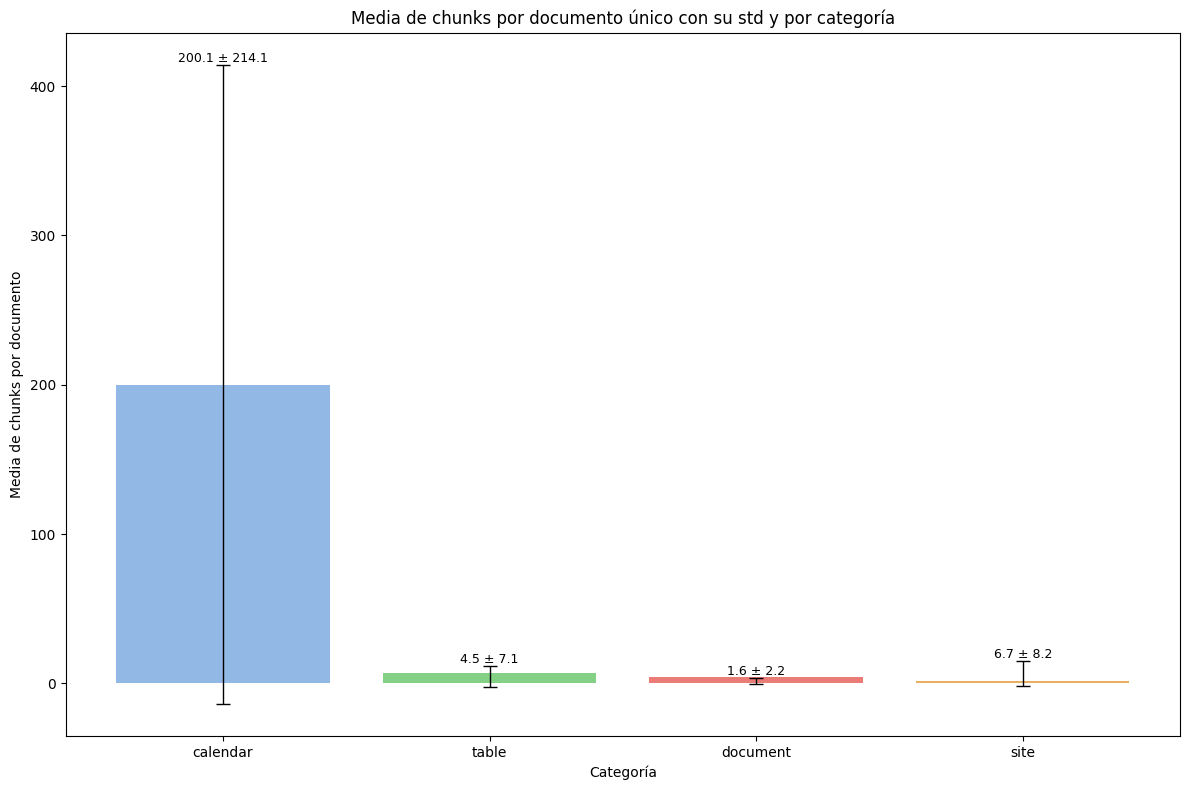

El gráfico muestra el número total de "chunks" por categoría en una escala logarítmica. Las categorías representadas son "document", "calendar", "site" y "table". 

Las principales tendencias y conclusiones son las siguientes:

1. **Document**: Es la categoría con el mayor número de chunks, con un total de 3404.
2. **Calendar**: Ocupa el segundo lugar con 1601 chunks.
3. **Site**: Tiene 676 chunks, situándose en el tercer lugar.
4. **Table**: Es la categoría con el menor número de chunks, con solo 74.

La diferencia entre las categorías es significativa, especialmente entre "document" y "table", lo que indica una distribución desigual del número de chunks entre las diferentes categorías.


In [45]:
warnings.filterwarnings("ignore")
fig=plot_chunks_per_doc_id()
fig_array = fig_to_image(fig)
interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)
print(interpretation)

Creamos grupos en el espacio, en función de su categoría. 'clusters por categoría'

In [46]:
content_vectors = np.array(embeddings_df['content_vector_norm'].tolist())

# Step 1: Add content_vector_norm to embeddings_df for easier access
embeddings_df['content_vector_norm'] = content_vectors.tolist()

# Step 2: Calculate the centroid for each category
centroids = embeddings_df.groupby('category')['content_vector_norm'].apply(lambda x: np.mean(np.array(x.tolist()), axis=0)).reset_index()
centroids.columns = ['category', 'center_category']

# Step 3: Merge the centroids back into the original embeddings_df
embeddings_df = embeddings_df.merge(centroids, on='category', how='left')

In [47]:
def plot_centroid_distances():
    """
    This function computes the distances between centroids of categories 
    and plots a heatmap of those distances.

    Parameters:
    embeddings_df (DataFrame): The dataframe containing 'category' and 'content_vector_norm'

    Returns:
    fig (matplotlib.figure.Figure): The figure object containing the heatmap plot
    """
    # Step 1: Calculate the centroids of each category
    centroids = embeddings_df.groupby('category')['content_vector_norm'].apply(
        lambda x: np.mean(np.array(x.tolist()), axis=0)
    ).reset_index()
    centroids.columns = ['category', 'center_category']

    # Convert 'center_category' to a NumPy array for distance calculations
    centroid_vectors = np.array(centroids['center_category'].tolist())

    # Step 2: Compute the distance matrix (pairwise distances between centroids)
    distance_matrix = squareform(pdist(centroid_vectors))

    # Step 3: Create a DataFrame for the distance matrix
    distance_df = pd.DataFrame(distance_matrix, columns=centroids['category'], index=centroids['category'])

    # Step 4: Create a mask for the lower triangle of the distance matrix
    mask = np.tril(np.ones_like(distance_df, dtype=bool), k=-1)

    # Step 5: Create a heatmap of the lower triangle distances using a new color palette
    fig = plt.figure(figsize=(10, 8))
    sns.heatmap(distance_df, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)

    # Title and labels
    plt.title('Distance Between Centroids of Categories', fontsize=16)
    plt.xlabel('Category', fontsize=12)
    plt.ylabel('Category', fontsize=12)

    # Return the figure object
    return fig

El gráfico muestra una matriz de distancias entre los centroides de diferentes categorías: "calendar", "document", "site" y "table". Los valores en la matriz representan la distancia entre los centroides de cada par de categorías, con un rango de 0 a 0.67.

Principales observaciones:

1. **Distancias más cortas**:
   - La distancia entre "document" y "site" es la más corta entre diferentes categorías, con un valor de 0.31.
   - La distancia entre "document" y "table" también es relativamente corta, con un valor de 0.40.

2. **Distancias más largas**:
   - La distancia entre "calendar" y "table" es la más larga, con un valor de 0.67.
   - La distancia entre "calendar" y "site" también es considerablemente larga, con un valor de 0.53.

3. **Distancias nulas**:
   - Las distancias entre una categoría y sí misma son 0, lo cual es esperado y se muestra en la diagonal principal de la matriz.

4. **Tendencias generales**:
   - "Calendar" parece estar más alejado de las otras categorías en com

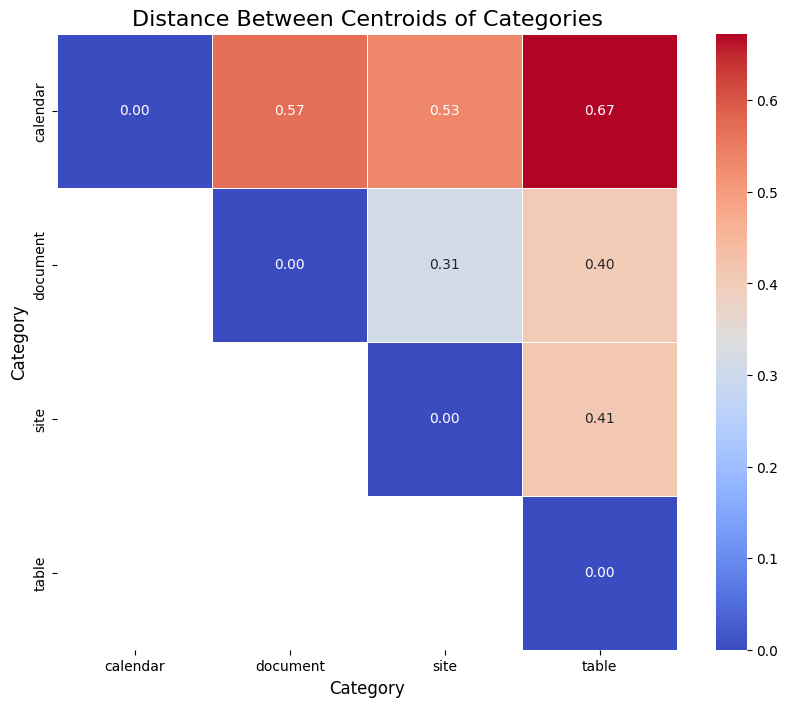

In [57]:
warnings.filterwarnings("ignore")
fig=plot_centroid_distances()
fig_array = fig_to_image(fig)
interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)
print(interpretation)

## III) Análisis en función del cluster

Asignamos un número a cada etiqueta

In [21]:
# Paso 1: Crear un diccionario para asignar números a cada etiqueta
etiquetas_unicas = embeddings_df['etiqueta_asignada'].unique()
etiqueta_dict = {etiqueta: i for i, etiqueta in enumerate(etiquetas_unicas)}

# Paso 2: Crear una nueva columna en el DataFrame
embeddings_df['etiqueta_numero'] = embeddings_df['etiqueta_asignada'].map(etiqueta_dict)

Visualización por tipo de documento y cluster

In [49]:
def plot_proportions_with_seaborn():
    """
    This function creates a stacked bar plot using Seaborn to visualize the proportions of categories
    within each cluster ('etiqueta_asignada'), with custom color mapping.

    Parameters:
    embeddings_df (DataFrame): The dataframe containing the embeddings data, with 'etiqueta_asignada', 'category', and 'count'.
    etiqueta_dict (dict): A dictionary to map 'etiqueta_asignada' values to numerical labels for sorting.
    
    Returns:
    fig (matplotlib.figure.Figure): The figure object containing the plot.
    """
    # Paso 3: Agrupar por 'etiqueta_asignada' y 'category'
    grouped = embeddings_df.groupby(['etiqueta_asignada', 'category']).size().reset_index(name='count')

    # Paso 4: Calcular totales para cada 'etiqueta_asignada'
    grouped['total'] = grouped.groupby('etiqueta_asignada')['count'].transform('sum')

    # Paso 5: Calcular proporciones
    grouped['proportion'] = (grouped['count'] / grouped['total']) * 100
    grouped['proportion'] = grouped['proportion'].round(1)

    # Paso 6: Sort values by 'etiqueta_numero' for the x-axis
    grouped['etiqueta_numero'] = grouped['etiqueta_asignada'].map(etiqueta_dict)
    grouped = grouped.sort_values(by='etiqueta_numero')

    # Paso 7: Define color mapping
    color_mapping = {
        'document': '#ff6961',
        'site': '#FFB347',
        'calendar': '#84b6f4',
        'table': '#77dd77'
    }

    # Pivot the data to prepare it for stacked bar plotting
    pivoted = grouped.pivot_table(index='etiqueta_numero', columns='category', values='proportion', aggfunc='sum').fillna(0)

    # Step 8: Crear el gráfico de barras apiladas usando matplotlib
    ax = pivoted.plot(kind='bar', stacked=True, figsize=(12, 8), color=[color_mapping[cat] for cat in pivoted.columns])

    # Paso 9: Ajustar el diseño
    plt.title('Proporciones de Categorías para cada Cluster', fontsize=16)
    plt.xlabel('Cluster', fontsize=14)
    plt.ylabel('Proporción de chunks (%)', fontsize=14)
    plt.xticks(ticks=range(len(etiqueta_dict)), labels=[str(val) for val in etiqueta_dict.values()], fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Categoría', title_fontsize='13', fontsize='12', loc='upper left', bbox_to_anchor=(1, 1))

    # Paso 10: Mostrar el gráfico
    plt.tight_layout()  # Ajustar el gráfico para que no se corten las etiquetas
    plt.show()

    return plt.gcf()


In [50]:
def fig_to_image2(fig):
    """Convert a Matplotlib figure to a numpy array using Agg backend."""
    # Use the 'Agg' backend for rendering the figure to a canvas
    from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

    # Create a canvas from the figure
    canvas = FigureCanvas(fig)
    
    # Draw the figure on the canvas (this renders the plot)
    canvas.draw()
    
    # Convert the canvas to a numpy array (RGB values)
    # canvas.renderer.buffer_rgba() returns the RGBA data of the figure
    image_array = np.array(canvas.renderer.buffer_rgba())
    
    return image_array


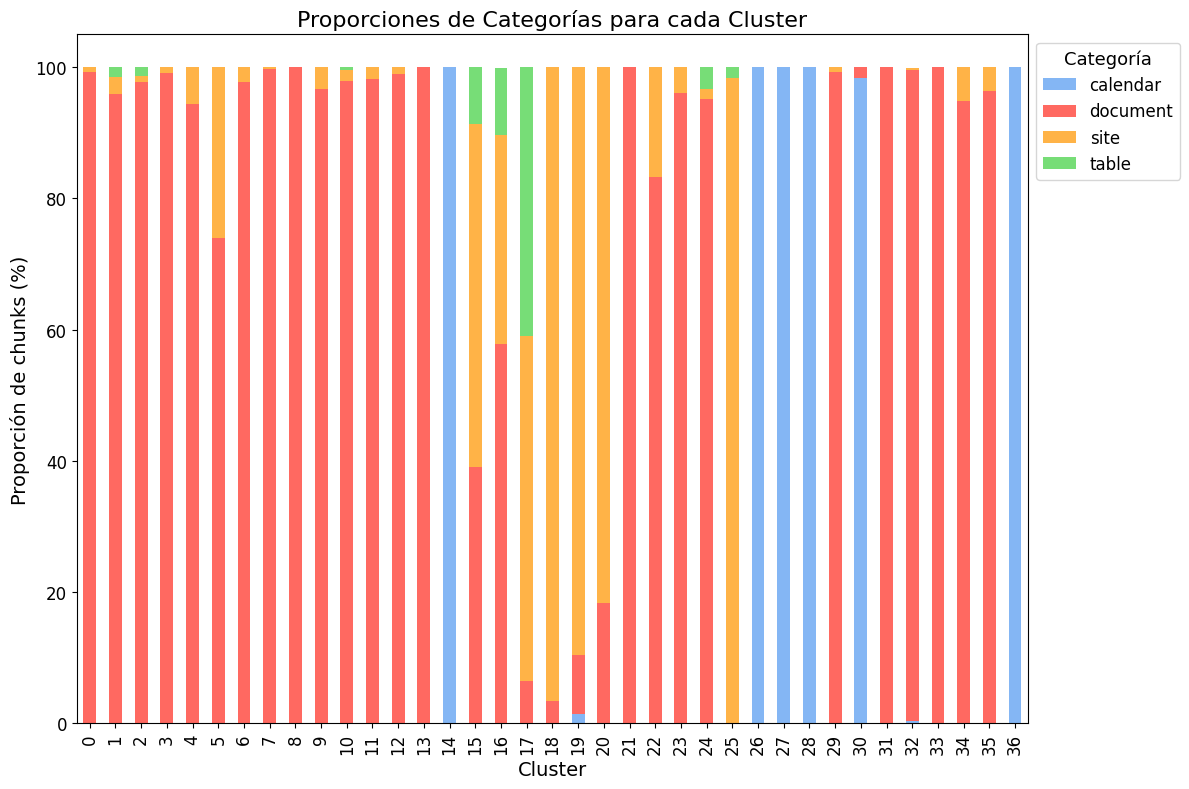

The image is completely white and does not contain any visible content or information. There are no elements, text, or graphics to analyze or describe.


<Figure size 640x480 with 0 Axes>

In [55]:
fig=plot_proportions_with_seaborn()
fig_array = fig_to_image2(fig)
interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)
print(interpretation)

Distribución de etiquetas

In [ ]:
def plot_document_stacked():
    """
    This function plots the mean number of chunks per document per cluster,
    with each cluster represented by stacked segments based on the 'color' column in the embeddings dataframe,
    using a custom color mapping.

    Parameters:
    embeddings_df (DataFrame): The dataframe containing 'etiqueta_numero', 'document_id', 'category', and 'color' for each entry.
    
    Returns:
    None: Displays the stacked bar plot.
    """
    # Define custom color mapping
    color_mapping = {
        'site': '#FFB347',
        'calendar': '#84b6f4',  
        'table': '#77dd77',    
        'document': '#ff6961',      
    }

    embeddings_df['color'] = embeddings_df['category'].map(color_mapping)
    
    # Group by 'etiqueta_numero' (cluster), 'color', and 'document_id' to count chunks
    chunk_count_per_document_color = embeddings_df.groupby(['etiqueta_numero', 'color', 'document_id']).size().reset_index(name='chunk_count')
    
    # Pivot the dataframe to create a matrix where each column corresponds to a color per cluster
    chunk_count_pivot = chunk_count_per_document_color.pivot_table(index='etiqueta_numero', columns='color', values='chunk_count', aggfunc='sum', fill_value=0)

    # Create the stacked bar plot
    ax = chunk_count_pivot.plot(kind='bar', stacked=True, figsize=(16, 8), width=0.8, color=color_mapping.values())

    # Add the values on top of each segment of the bar
    for i, cluster in enumerate(chunk_count_pivot.index):
        # Get the cumulative sum for each segment in the bar
        cumulative_sum = chunk_count_pivot.loc[cluster].cumsum()
        for j, color in enumerate(chunk_count_pivot.columns):
            if chunk_count_pivot.loc[cluster, color] > 0:
                plt.text(i, cumulative_sum[j] - chunk_count_pivot.loc[cluster, color] / 2, 
                         f'{chunk_count_pivot.loc[cluster, color]}', ha='center', va='center', fontsize=12, color='black')

    # Set plot titles and labels
    plt.title('Número total de chunks por cluster y categoría', fontsize=16)
    plt.xlabel('Cluster', fontsize=14)
    plt.ylabel('Número de chunks', fontsize=14)

    # Adjust the design for better layout
    plt.xticks(rotation=0)  # Ensure x-axis labels are readable
    plt.tight_layout()

    # Customizing the legend to correspond to the categories and their colors
    handles = [plt.Line2D([0], [0], color=color, lw=4) for color in color_mapping.values()]
    labels = list(color_mapping.keys())
    ax.legend(handles, labels, title="Categories")

    # Display the plot
    plt.show()

    return plt.gcf()


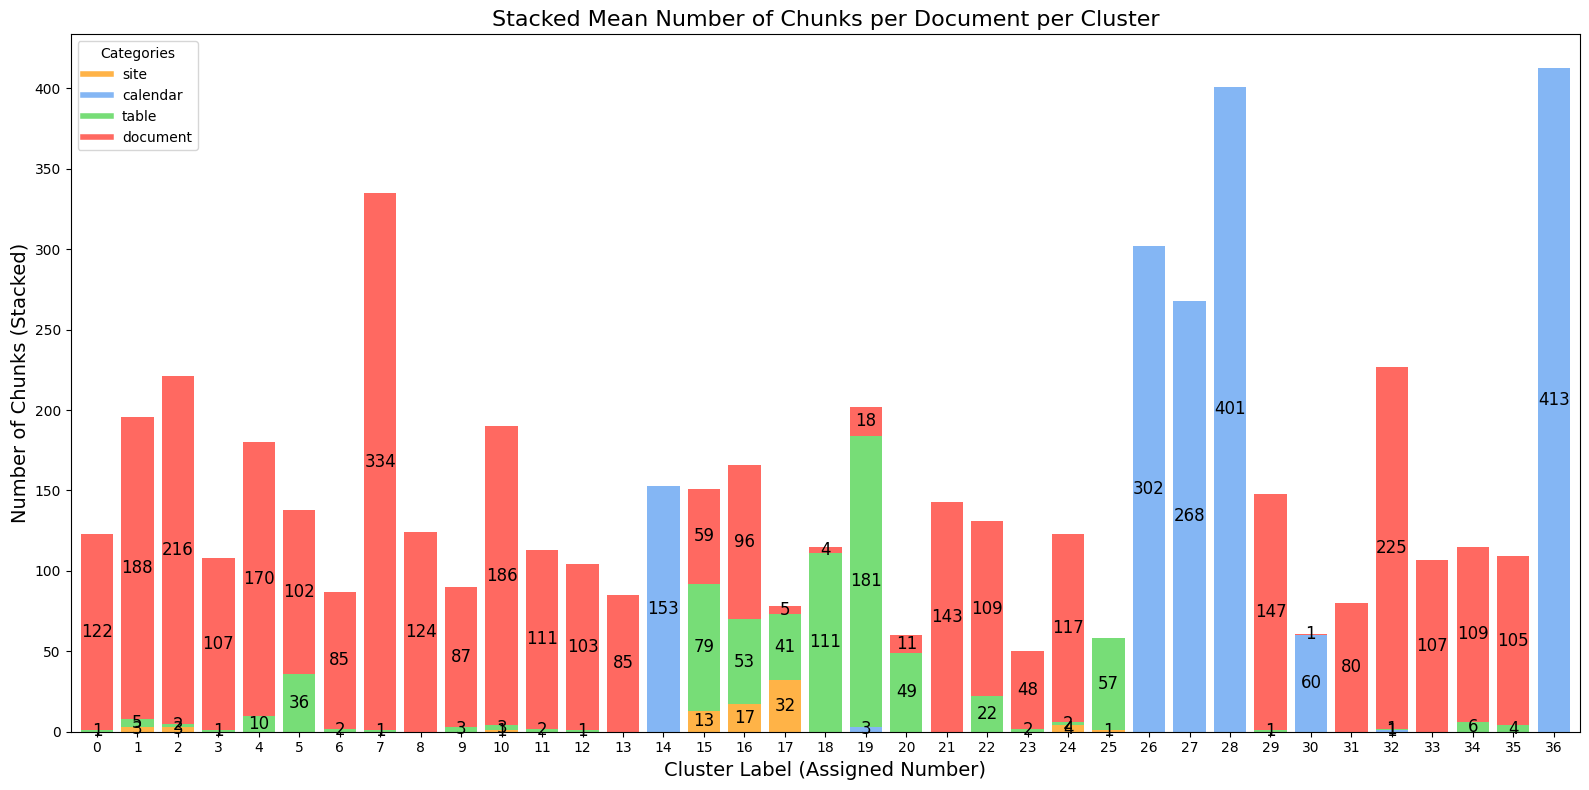

The image is completely white and blank. There are no visible elements, text, or graphics to describe or analyze.


<Figure size 640x480 with 0 Axes>

In [56]:
fig=plot_document_stacked()
fig_array = fig_to_image(fig)
interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)
print(interpretation)

In [57]:
columns_to_remove = [
        'center_category_x', 'is_outlier',
        'All_Same_Cluster_x', 'All_Same_Cluster_y', 'All_Same_Cluster',
        'center_category_y', 'All_Same_Cluster_Grouped_x', 
        'All_Same_Cluster_Grouped_y', 'All_Same_Cluster_Grouped'
    ]
embeddings_df.drop(columns=columns_to_remove, inplace=True, errors='ignore')

def docs_por_clus_cat(embeddings_df):    
    # Step 1: Group by 'document_id' and count unique clusters
    grouped = embeddings_df.groupby('document_id')['etiqueta_numero'].nunique().reset_index()

    # Step 2: Identify if all chunks of a document are in the same cluster
    grouped['All_Same_Cluster'] = grouped['etiqueta_numero'] == 1  # True if only one unique cluster

    # Merge the All_Same_Cluster flag back to the original DataFrame
    embeddings_df = embeddings_df.merge(
        grouped[['document_id', 'All_Same_Cluster']], 
        on='document_id', 
        how='left'
    )

    # Step 3: Create a DataFrame for counting based on 'All_Same_Cluster'
    count_status = (
        embeddings_df.groupby(['etiqueta_numero', 'All_Same_Cluster', 'category'])
        .size()
        .reset_index(name='Document_Count')
    )

    # Step 4: Create the plots for each cluster
    plt.figure(figsize=(14, 8))

    # Pivot the count_status for a stacked bar plot
    count_status_pivot = count_status.pivot_table(
        index='etiqueta_numero', 
        columns='category', 
        values='Document_Count', 
        fill_value=0
    )

    # Get the colors for each category from embeddings_df['color']
    color_mapping = embeddings_df.drop_duplicates('category')[['category', 'color']].set_index('category')['color'].to_dict()
    ax = count_status_pivot.plot(kind='bar', stacked=True, figsize=(14, 8), color=[color_mapping.get(cat) for cat in count_status_pivot.columns])
    ax.set_yscale('log')

    # Customize the plot
    plt.title('Número total de documentos para cada Cluster y indicando su categoría', fontsize=16)
    plt.xlabel('Cluster', fontsize=14)
    plt.ylabel('número de documentos en escala logarítmica ', fontsize=14)
    plt.xticks(rotation=0)
    plt.legend(title='Category', fontsize=12, title_fontsize=14)
    plt.tight_layout()  # To avoid cutting off labels

    return plt.gcf()

El gráfico muestra el número total de documentos para cada cluster, desglosado por categoría (calendar, document, site, table) en una escala logarítmica. Aquí están las principales observaciones:

1. **Predominio de la categoría "document"**: La mayoría de los clusters están dominados por la categoría "document" (color rojo), lo que indica que la mayoría de los documentos en estos clusters pertenecen a esta categoría.

2. **Clusters con alta cantidad de "calendar"**: Los clusters 14, 26, 27, 28, 30, 31, 32, 33, y 36 tienen una alta cantidad de documentos en la categoría "calendar" (color azul).

3. **Clusters con diversidad de categorías**: Algunos clusters, como el 15, 17, 18, 19, 20, y 24, muestran una mayor diversidad de categorías, incluyendo "site" (color naranja) y "table" (color verde).

4. **Clusters con menor cantidad de documentos**: Los clusters 6, 8, 10, 11, 12, 13, 16, 21, 22, y 34 tienen una menor cantidad de documentos en comparación con otros clusters.

5. **Escala loga

<Figure size 1400x800 with 0 Axes>

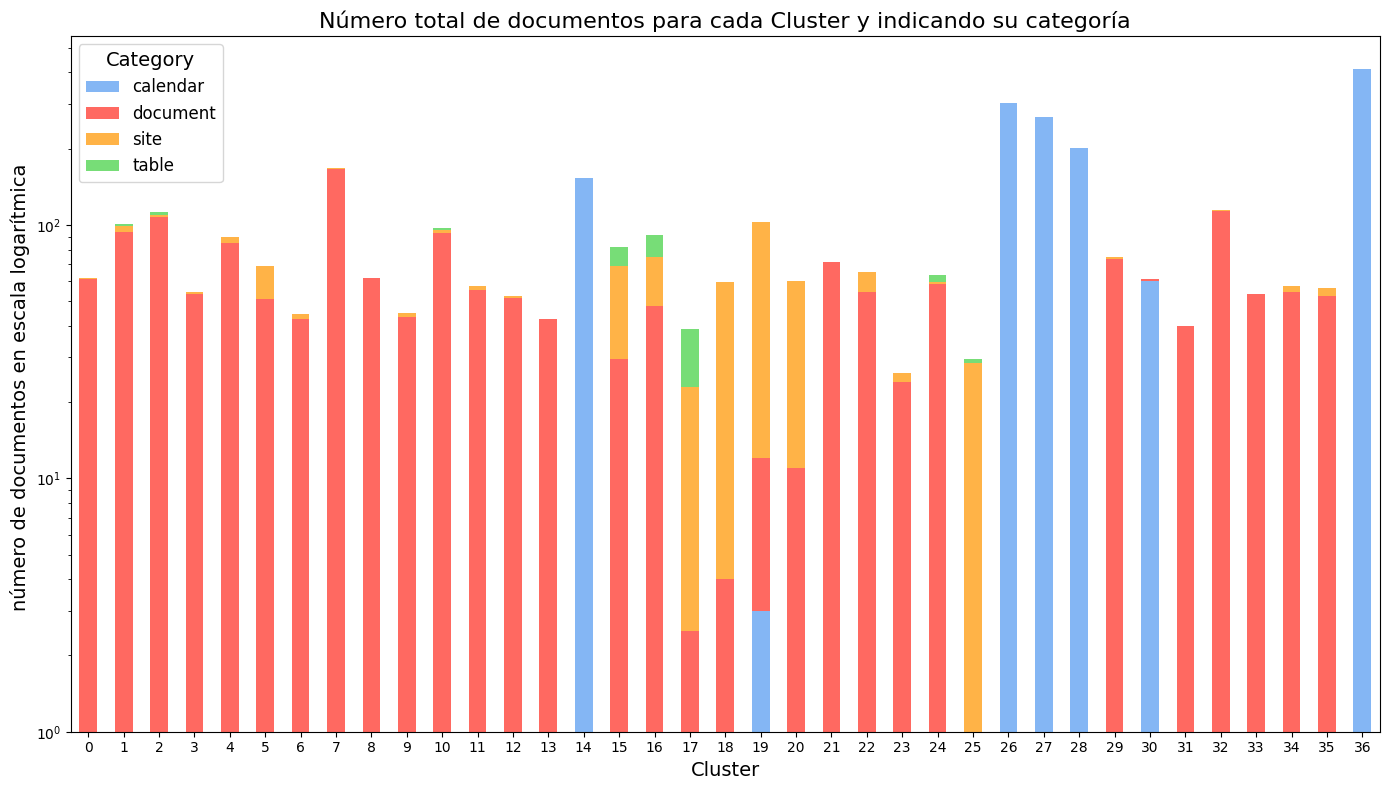

In [58]:
fig=docs_por_clus_cat(embeddings_df)
fig_array = fig_to_image(fig)
interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)
print(interpretation)

Para cada cluster, cuantos chunks pertenecen al mismo documento? (solo documentos con más de un chunk)

In [147]:
def chunks_por_clus_cat_seaborn(embeddings_df):
    # Eliminar las columnas innecesarias
    columns_to_remove = [
        'center_category_x', 'is_outlier',
        'All_Same_Cluster_x', 'All_Same_Cluster_y', 'All_Same_Cluster',
        'center_category_y', 'All_Same_Cluster_Grouped_x', 
        'All_Same_Cluster_Grouped_y', 'All_Same_Cluster_Grouped'
    ]
    embeddings_df.drop(columns=columns_to_remove, inplace=True, errors='ignore')

    # Step 1: Agrupar por 'document_id' y contar los clusters únicos
    grouped = embeddings_df.groupby('document_id')['chunk_id'].nunique().reset_index()
    
    # Filter documents that have more than 1 chunk_id
    grouped = grouped[grouped['chunk_id'] > 1]
    
    # Merge el filtro de 'document_id' con el dataframe original
    embeddings_df = embeddings_df[embeddings_df['document_id'].isin(grouped['document_id'])]

    # Step 2: Agrupar nuevamente por 'document_id' y contar los clusters únicos
    grouped = embeddings_df.groupby('document_id')['etiqueta_numero'].nunique().reset_index()
    grouped['All_Same_Cluster'] = grouped['etiqueta_numero'] == 1

    # Merge el flag de 'All_Same_Cluster' de vuelta al dataframe original
    embeddings_df = embeddings_df.merge(
        grouped[['document_id', 'All_Same_Cluster']], 
        on='document_id', 
        how='left'
    )

    # Step 3: Crear un DataFrame para contar basado en 'All_Same_Cluster'
    count_status = (
        embeddings_df.groupby(['etiqueta_numero', 'All_Same_Cluster', 'category'])
        .size()
        .reset_index(name='Document_Count')
    )

    # Step 4: Crear los subgráficos
    unique_clusters = embeddings_df['etiqueta_numero'].unique()
    n_clusters = len(unique_clusters)

    # Definir el número de columnas para el diseño de la cuadrícula
    n_cols = 7  # Ajusta según sea necesario
    n_rows = (n_clusters + n_cols - 1) // n_cols  # Calcular filas necesarias

    # Crear una figura con subgráficos
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3 * n_rows))
    axes = axes.flatten()  # Aplanar el arreglo de ejes

    # Step 5: Crear el gráfico de barras apiladas para cada cluster
    for i, cluster in enumerate(unique_clusters):
        ax = axes[i]
        cluster_data = count_status[count_status['etiqueta_numero'] == cluster]
        
        # Crear gráfico apilado para cada cluster
        sns.barplot(
            data=cluster_data,
            x='All_Same_Cluster',
            y='Document_Count',
            hue='category',
            ax=ax,
            dodge=False,  # Asegurarse de que las barras estén apiladas
            palette=embeddings_df.drop_duplicates('category')[['category', 'color']].set_index('category')['color'].to_dict()  # Usar colores personalizados
        )
        
        # Configurar título y etiquetas
        ax.set_title(f'Cluster {cluster}', fontsize=14)
        ax.set_ylabel('Número de chunks', fontsize=12)
        ax.legend(title='Categoría', fontsize=10)
        ax.legend().set_visible(False)

    # Eliminar ejes vacíos si los hay
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.suptitle('Para cada cluster, cuántos chunks pertenecen al mismo documento?', fontsize=18, y=1.02) 
    handles, labels = [], []
    for ax in axes:
        for handle, label in zip(*ax.get_legend_handles_labels()):
            if label not in labels:  # Solo agregar si la etiqueta no está ya en la lista
                handles.append(handle)
                labels.append(label)
    
    # Mostrar la leyenda una sola vez, fuera de los subgráficos
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title='Categoría', fontsize=12)
    plt.tight_layout()
    
    return plt.gcf()


El gráfico muestra la distribución de "chunks" (fragmentos) que pertenecen al mismo documento dentro de cada cluster, categorizados por tipo de contenido (document, table, site, calendar). Cada subgráfico representa un cluster diferente, con el eje y indicando el número de chunks y el eje x indicando si todos los chunks pertenecen al mismo documento (True) o no (False).

Principales observaciones:

1. **Clusters Dominados por Documentos**: La mayoría de los clusters (por ejemplo, Clusters 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 21, 22, 23, 24, 25, 28, 29, 30, 31, 32, 33, 34, 35) están dominados por chunks de tipo "document", especialmente en la categoría "True".

2. **Clusters con Diversidad de Categorías**: Algunos clusters muestran una mezcla de categorías. Por ejemplo:
   - Cluster 15 tiene una mezcla de "document" y "table".
   - Cluster 16 tiene una mezcla de "document", "table" y "site".
   - Cluster 17 tiene una mezcla de "document", "table" y "calendar".
   - Cluster 18 t

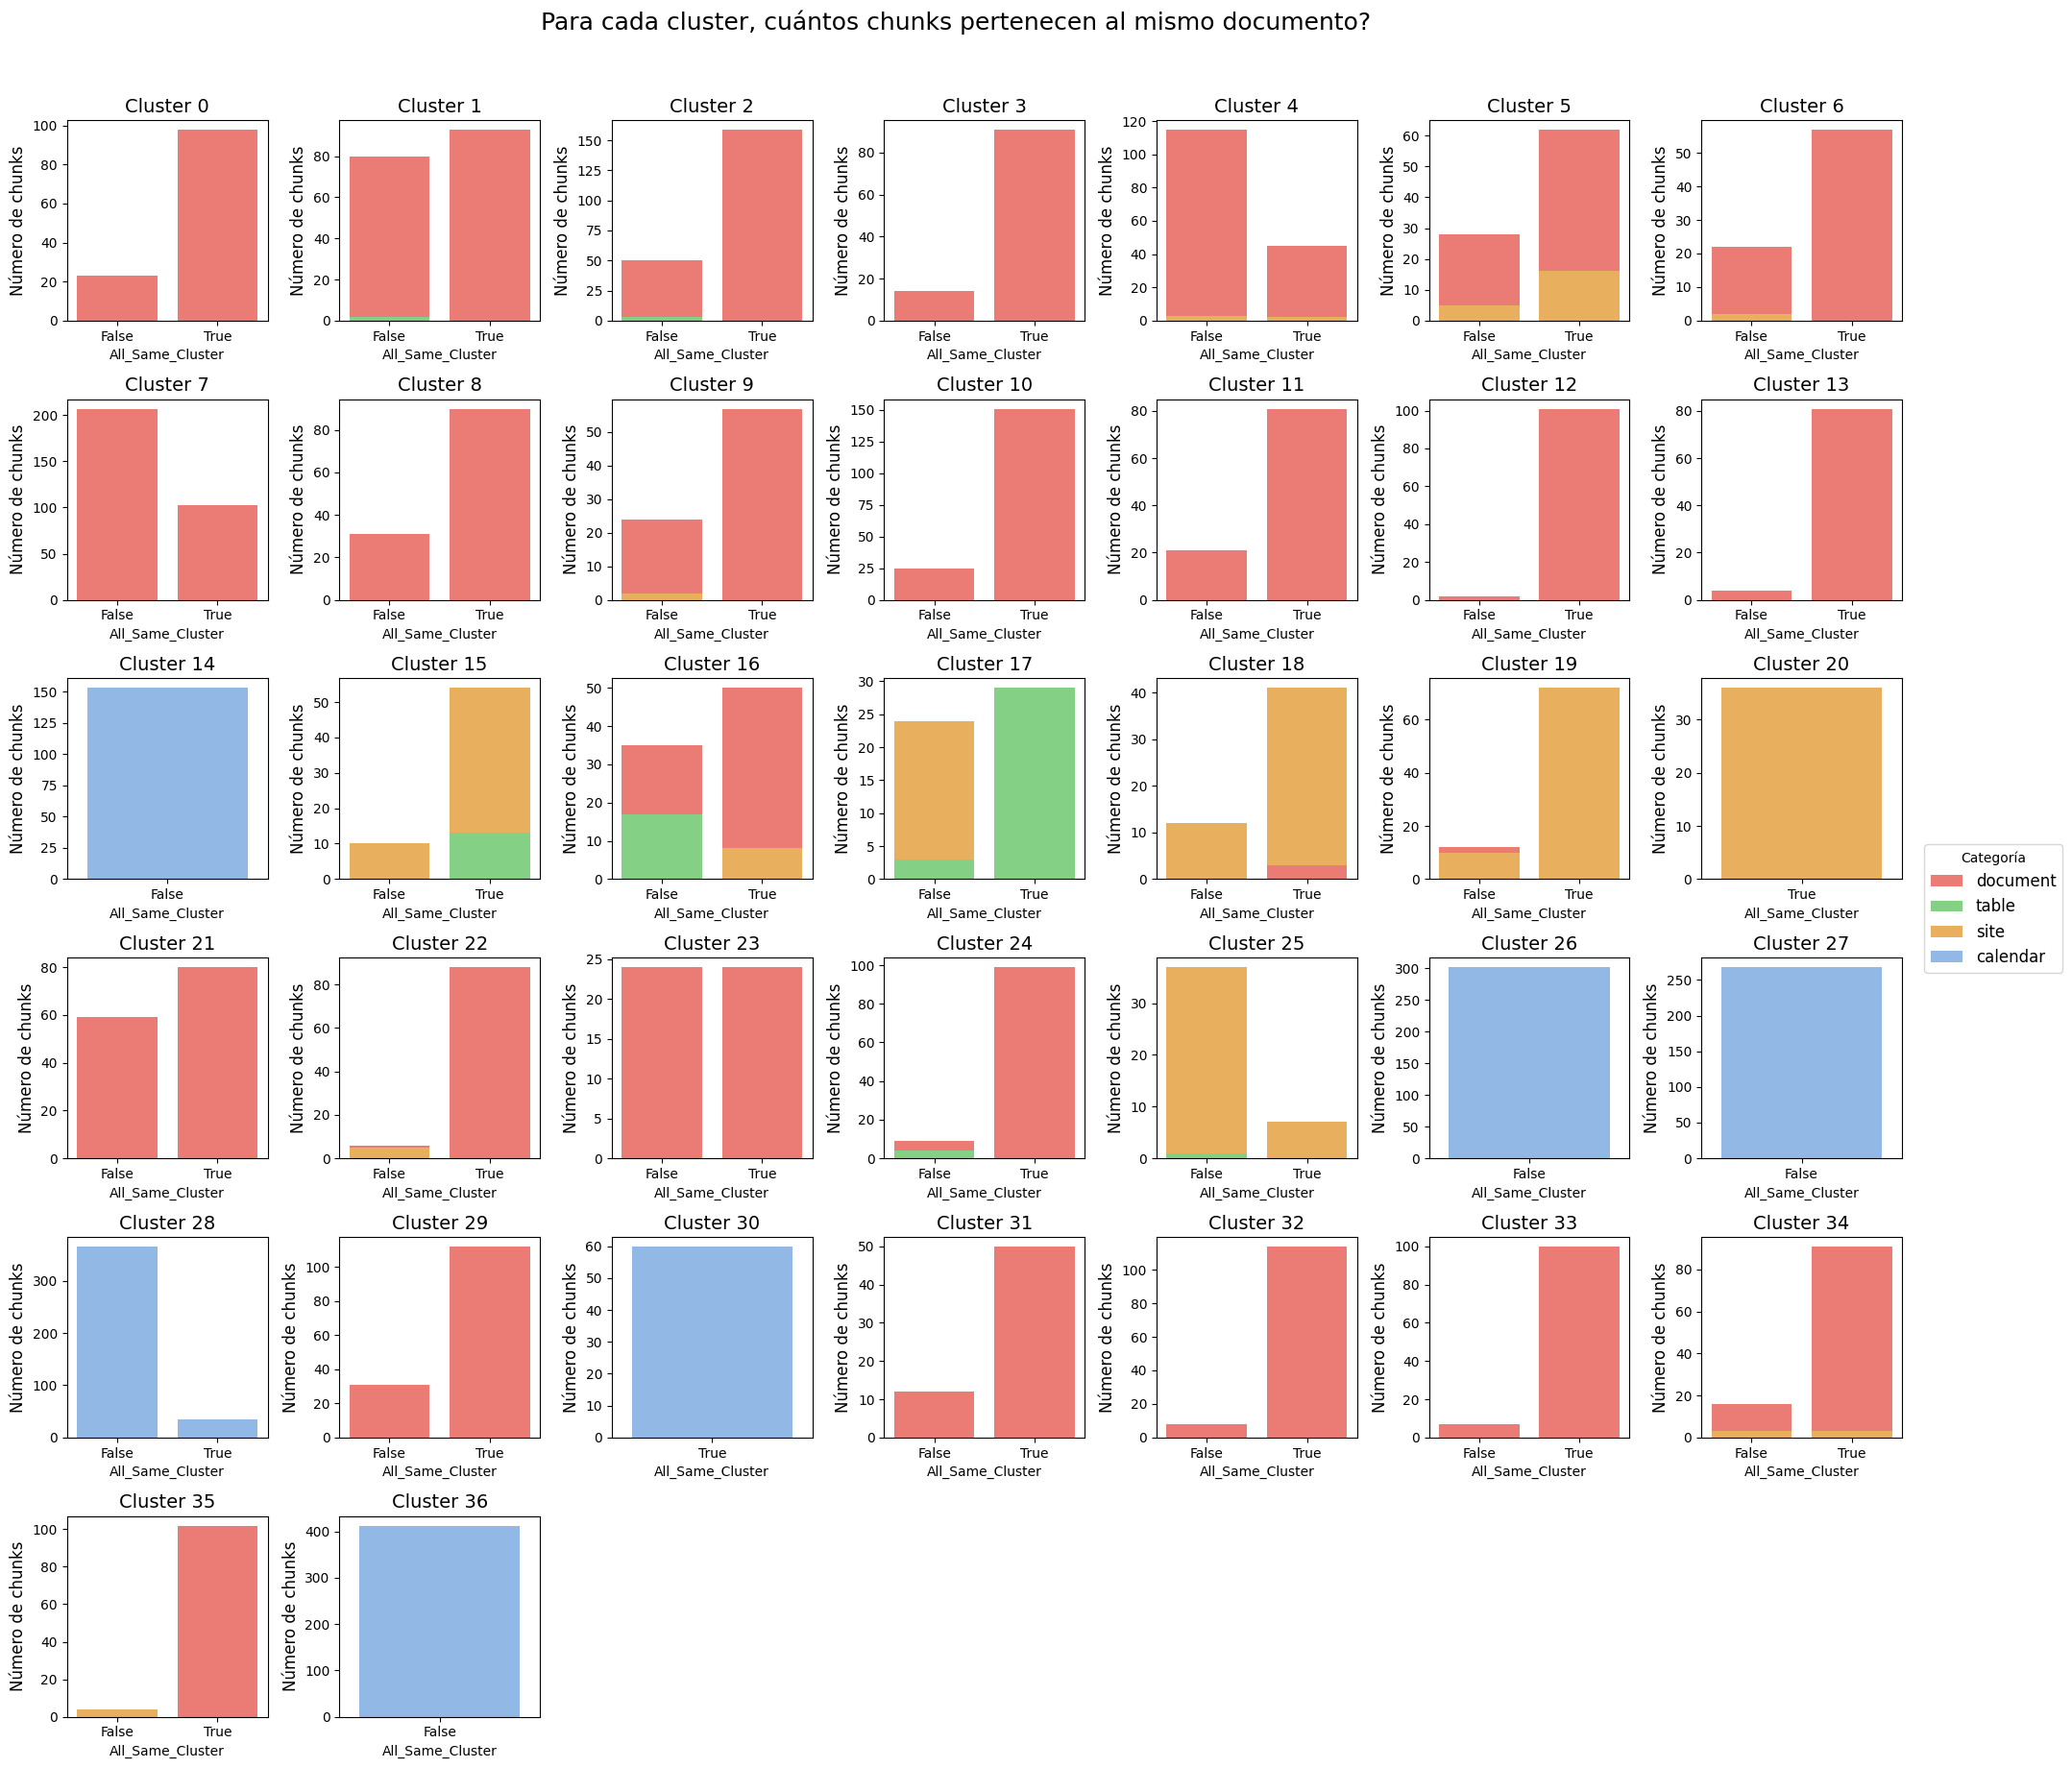

In [142]:
fig=chunks_por_clus_cat_seaborn(embeddings_df)
fig_array = fig_to_image(fig)
interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)
print(interpretation)

1) Coger los documentos TRUE

In [236]:
def docs_por_clus_cat_seaborn_and_extract(embeddings_df):
    # Eliminar las columnas innecesarias
    columns_to_remove = [
        'center_category_x', 'is_outlier',
        'All_Same_Cluster_x', 'All_Same_Cluster_y', 'All_Same_Cluster',
        'center_category_y', 'All_Same_Cluster_Grouped_x', 
        'All_Same_Cluster_Grouped_y', 'All_Same_Cluster_Grouped'
    ]
    embeddings_df.drop(columns=columns_to_remove, inplace=True, errors='ignore')

    # Agrupar por 'document_id' y contar los clusters únicos
    grouped = embeddings_df.groupby('document_id')['chunk_id'].nunique().reset_index()
    
    # Filtrar documentos que tienen más de 1 chunk_id
    grouped = grouped[grouped['chunk_id'] > 1]
    
    # Merge el filtro de 'document_id' con el dataframe original
    embeddings_df = embeddings_df[embeddings_df['document_id'].isin(grouped['document_id'])]

    # Agrupar nuevamente por 'document_id' y contar los clusters únicos
    grouped = embeddings_df.groupby('document_id')['etiqueta_numero'].nunique().reset_index()
    grouped['All_Same_Cluster'] = grouped['etiqueta_numero'] == 1

    # Merge el flag de 'All_Same_Cluster' de vuelta al dataframe original
    embeddings_df = embeddings_df.merge(
        grouped[['document_id', 'All_Same_Cluster']], 
        on='document_id', 
        how='left'
    )

    # Filtrar solo aquellos documentos donde 'All_Same_Cluster' es True
    documents_with_same_cluster = embeddings_df[embeddings_df['All_Same_Cluster'] == True]

    # Guardar las variables de estos documentos (se puede almacenar como DataFrame o exportar a un archivo)
    # Aquí guardamos en un nuevo DataFrame
    extracted_data = documents_with_same_cluster.copy()

    return extracted_data


In [237]:
data_documents_true = docs_por_clus_cat_seaborn_and_extract(embeddings_df)

In [238]:
columns_to_remove = ['content_vector', 'content_vector_norm', 'chunk_id', 'All_Same_Cluster', 'center_category', 'centroide']
data_documents_true.drop(columns=columns_to_remove, inplace=True, errors='ignore')
unique_documents = data_documents_true.groupby('document_id').first().reset_index()
unique_documents.head()

,document_id,original_path,id,content,content_type,category,etiqueta_asignada,color,etiqueta_numero
0,admondch_departamento_formacion_gestion_docume...,https://elcorteingles.sharepoint.com/:b:/r/sit...,admondch_departamento_formacion_gestion_docume...,Consulta Pedido ![](figures/0) El Corte Inglé...,pdf,document,"Encargos, gestión de pedidos, atención al clie...",#ff6961,7
1,admondch_departamento_formacion_gestion_docume...,https://elcorteingles.sharepoint.com/:b:/r/sit...,admondch_departamento_formacion_gestion_docume...,Paso 4/10 Salesforce Llegamos a la pantalla “C...,pdf,document,"Clientes, gestión de casos, encuestas de satis...",#ff6961,2
2,admondch_departamento_formacion_gestion_docume...,https://elcorteingles.sharepoint.com/:b:/r/sit...,admondch_departamento_formacion_gestion_docume...,Apertura Nuevo Caso Salesforce\n 05 Vuelvo al ...,pdf,document,"Clientes, gestión de casos, encuestas de satis...",#ff6961,2
3,admondch_departamento_formacion_gestion_docume...,https://elcorteingles.sharepoint.com/:b:/r/sit...,admondch_departamento_formacion_gestion_docume...,La tabla presenta información relacionada con ...,pdf,document,"Compatibilidad de dispositivos, requisitos de ...",#ff6961,9
4,admondch_departamento_formacion_gestion_docume...,https://elcorteingles.sharepoint.com/:b:/s/Adm...,admondch_departamento_formacion_gestion_docume...,Abonos\n ABONOS Administración DCH MANUAL de ...,pdf,document,"Archivos transferencias, gestión de abonos, in...",#ff6961,8


In [212]:
grouped = unique_documents.groupby(['etiqueta_asignada', 'etiqueta_numero'])['original_path']

sorted_groups = sorted(grouped, key=lambda x: x[0][1])  # Sorting by 'etiqueta_numero' (second element of tuple)

# Iterate over each group and print the 'original_path' values along with 'etiqueta_asignada' and 'etiqueta_numero'
for (etiqueta_asignada, etiqueta_numero), original_paths in sorted_groups:
    print(f"Etiqueta Asignada: {etiqueta_asignada}, Etiqueta Numero: {etiqueta_numero}")
    print("Document Paths:")
    for path in original_paths:
        print(path)
    print("\n")  # Newline for better readability between groups 

Etiqueta Asignada: Envío a domicilio, gestión de pedidos, modificación de datos, lista rápida, atención al cliente, Etiqueta Numero: 0
Document Paths:
https://elcorteingles.sharepoint.com/:b:/r/sites/AyudaDCH/Documentos%20compartidos/COPILOT/MANUALES%20DE%20FORMACION/SUPERMERCADO/CAPTURA_PEDIDOS_GPER.pdf?csf=1&web=1&e=gEXb3T
https://elcorteingles.sharepoint.com/:b:/r/sites/AyudaDCH/Documentos%20compartidos/COPILOT/MANUALES%20DE%20FORMACION/SUPERMERCADO/CAPTURA_PEDIDOS_WEB.pdf?csf=1&web=1&e=KGhMcs
https://elcorteingles.sharepoint.com/:b:/r/sites/AyudaDCH/Documentos%20compartidos/COPILOT/MANUALES%20DE%20FORMACION/SUPERMERCADO/Guia%20GPER.pdf?csf=1&web=1&e=y7nYsr
https://elcorteingles.sharepoint.com/:b:/r/sites/AyudaDCH/Documentos%20compartidos/COPILOT/MANUALES%20DE%20FORMACION/SUPERMERCADO/LIBERACION%20PEDIDOS%20RETENIDOS%20GPER.pdf?csf=1&web=1&e=S53vgw
https://elcorteingles.sharepoint.com/:b:/s/AyudaDCH/EYLwBD7XCChHorMIa5tedPwBJxk-R7gxxevKPEzpC9hRvw?e=pJtGfZ
https://elcorteingles.sharep

2) Coger los chunks en FALSE

In [228]:
def chunks_por_clus_cat_seaborn_and_extract(embeddings_df):
    # Eliminar las columnas innecesarias
    columns_to_remove = [
        'center_category_x', 'is_outlier',
        'All_Same_Cluster_x', 'All_Same_Cluster_y', 'All_Same_Cluster',
        'center_category_y', 'All_Same_Cluster_Grouped_x', 
        'All_Same_Cluster_Grouped_y', 'All_Same_Cluster_Grouped'
    ]
    embeddings_df.drop(columns=columns_to_remove, inplace=True, errors='ignore')

    # Agrupar por 'document_id' y contar los clusters únicos
    grouped = embeddings_df.groupby('document_id')['chunk_id'].nunique().reset_index()
    
    # Filtrar documentos que tienen más de 1 chunk_id
    grouped = grouped[grouped['chunk_id'] > 1]
    
    # Merge el filtro de 'document_id' con el dataframe original
    embeddings_df = embeddings_df[embeddings_df['document_id'].isin(grouped['document_id'])]

    # Agrupar nuevamente por 'document_id' y contar los clusters únicos
    grouped = embeddings_df.groupby('document_id')['etiqueta_numero'].nunique().reset_index()
    grouped['All_Same_Cluster'] = grouped['etiqueta_numero'] == 1

    # Merge el flag de 'All_Same_Cluster' de vuelta al dataframe original
    embeddings_df = embeddings_df.merge(grouped[['document_id', 'All_Same_Cluster']], 
        on='document_id', 
        how='left')

    # Filtrar solo aquellos documentos donde 'All_Same_Cluster' es False
    documents_with_dist_cluster = embeddings_df[embeddings_df['All_Same_Cluster'] == False]

    # Guardar las variables de estos documentos (se puede almacenar como DataFrame o exportar a un archivo)
    # Aquí guardamos en un nuevo DataFrame
    extracted_data = documents_with_dist_cluster.copy()


    return extracted_data


In [229]:
data_chunks_false = chunks_por_clus_cat_seaborn_and_extract(embeddings_df)

In [230]:
columns_to_remove = ['content_vector', 'content_vector_norm', 'chunk_id', 'All_Same_Cluster', 'center_category', 'centroide']
data_chunks_false.drop(columns=columns_to_remove, inplace=True, errors='ignore')

data_chunks_false = data_chunks_false.groupby('document_id').first().reset_index()

data_chunks_false.head()

,document_id,original_path,id,content,content_type,category,etiqueta_asignada,color,etiqueta_numero
0,admondch_departamento_formacion_gestion_docume...,https://elcorteingles.sharepoint.com/:b:/r/sit...,admondch_departamento_formacion_gestion_docume...,PARADA DE RELOJ\n Instrucciones para detener e...,pdf,document,"Encargos, gestión de pedidos, atención al clie...",#ff6961,7
1,admondch_departamento_formacion_gestion_docume...,https://elcorteingles.sharepoint.com/:b:/s/Adm...,admondch_departamento_formacion_gestion_docume...,La tabla describe una estructura de registros ...,pdf,document,"Archivos transferencias, gestión de abonos, in...",#ff6961,8
2,admondch_departamento_formacion_gestion_docume...,https://elcorteingles.sharepoint.com/:b:/s/Adm...,admondch_departamento_formacion_gestion_docume...,4 . GESTIÓN DE CARTERAS MARKETPLACE 4.1 . Reco...,pdf,document,"Cambios y devoluciones, gestión de incidencias...",#ff6961,34
3,admondch_departamento_formacion_gestion_docume...,https://elcorteingles.sharepoint.com/:b:/r/sit...,admondch_departamento_formacion_gestion_docume...,Producto diferente / mercancía incompleta o de...,pdf,document,"Responsabilidad documental, estructuras de tab...",#ff6961,1
4,admondch_departamento_formacion_gestion_docume...,https://elcorteingles.sharepoint.com/:b:/s/Adm...,admondch_departamento_formacion_gestion_docume...,1 . INTRODUCCION A través de La Tienda en Casa...,pdf,document,"Archivos transferencias, gestión de abonos, in...",#ff6961,8


In [243]:
sorted_data = data_chunks_false.sort_values(by=['etiqueta_numero', 'etiqueta_asignada'])

grouped = sorted_data.groupby(['etiqueta_asignada', 'etiqueta_numero', 'content'])['original_path']

for (etiqueta_asignada, etiqueta_numero, content), original_paths in grouped:
    print(f"Etiqueta Asignada: {etiqueta_asignada}, Etiqueta Numero: {etiqueta_numero}")
    print("Document Paths and Content:")
    
    for path in original_paths:
        print(f"Path: {path}, Content: {content}")
    
    print("\n")


Etiqueta Asignada: Anulaciones pedidos, atención al cliente, devoluciones internacionales, cambios envíos internacionales, gestión de incidencias, Etiqueta Numero: 16
Document Paths and Content:
Path: https://elcorteingles.sharepoint.com/sites/VentasDCH/Documentos%20compartidos/DEPARTAMENTO%20FORMACION/GESTION%20DOCUMENTAL/TELEMARKETING/GESTION%20TELEMARKETING%20-%20Env%C3%ADo%20de%20correos%20publicitarios.pdf, Content:  TELEMARKETING envío de correos publicitarios
 Gestión Telemarketing Envío de Correos publicitarios ![](figures/0) Formación DCH febrero 2024 O DIGITAL CONTACT HUB El Corte Inglés  
 OPERATIVA ANTE LA SOLICITUD DE INFORMACIÓN DE UN PRODUCTO TELEMARKETING envío de correos publicitarios En algunas ocasiones los clientes que son informados de una oferta comercial emitida desde una campaña de Telemarketing solicitan el envío de más información para poder valorar la oferta.
 Campaña Campaña Telemarketing Se emite desde Interaction Desktop /SAP CRM. Los clientes de Telemarke

### Cálculo de valores atípicos

1) z-score (calculo con la media que las distancias de las 3000 dimensiones de un embedding por lo que no es correcto)

In [ ]:
def zscore():

    def plot_boxplots_and_identify_outliers(cluster_data, etiqueta_asignada):
        # Calculate the centroid
        centroid = np.mean(cluster_data, axis=0)
        distances = pairwise.euclidean_distances(cluster_data, [centroid]).flatten()
        
        mean_distance = np.mean(distances)
        std_distance = np.std(distances)

        z_scores = (distances - mean_distance) / std_distance
        threshold = 3  #  values that are more than 3 standard deviations away from the mean.
        outliers = distances[z_scores > threshold]

        data_to_plot = pd.DataFrame({'Distancia': distances, 'Cluster': etiqueta_asignada})
        return data_to_plot, mean_distance, threshold, len(outliers), len(cluster_data)
    
    combined_data = pd.DataFrame()
    for label in embeddings_df['etiqueta_numero'].unique():
        cluster_data = np.array(embeddings_df[embeddings_df['etiqueta_numero'] == label]['content_vector_norm'].tolist())
        data_to_plot, mean_distance, threshold, num_outliers, total_embeddings = plot_boxplots_and_identify_outliers(cluster_data, label)

        combined_data = pd.concat([combined_data, data_to_plot], ignore_index=True) 
        if num_outliers > 0:
            per_outliers = (num_outliers * 100 / total_embeddings) if total_embeddings > 0 else 0
            per_outliers = round(per_outliers, 3)
            print(f'Cluster: {label}')
            print(f'{num_outliers} outliers identified from {total_embeddings} total embeddings.')
            print(f'Percentage of total outliers is {per_outliers}%.')
            print()
    plt.figure(figsize=(15, 10))
    sns.boxplot(data=combined_data, x='Cluster', y='Distancia', 
                palette='pastel') 
    plt.title('Boxplots con valores atípicos (Valores que están a más de 3 std de la media.)', fontsize=16)
    plt.xlabel('Cluster', fontsize=14)
    plt.ylabel('Dsitancia al centroide', fontsize=14)
    return plt.gcf()

In [ ]:
warnings.filterwarnings("ignore")
fig=zscore()
fig_array = fig_to_image(fig)
interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)
print(interpretation)


0.529607551431916
0.63231955613878
Cluster: 1
1 outliers identified from 196 total embeddings.
Percentage of total outliers is 0.51%.

0.5484603986371851
0.5874148366358005
Cluster: 3
2 outliers identified from 108 total embeddings.
Percentage of total outliers is 1.852%.

0.6348653731459374
Cluster: 4
2 outliers identified from 180 total embeddings.
Percentage of total outliers is 1.111%.

0.6417762589282395
Cluster: 5
2 outliers identified from 138 total embeddings.
Percentage of total outliers is 1.449%.

0.5669126879170491
0.5432143628850131
0.5710097270744674
0.5736260572007529
0.6592384559435005
Cluster: 10
1 outliers identified from 190 total embeddings.
Percentage of total outliers is 0.526%.

0.5588608191173384
0.4386983716638419
Cluster: 12
1 outliers identified from 104 total embeddings.
Percentage of total outliers is 0.962%.

0.46470359863991745
0.38239889111659026
Cluster: 14
1 outliers identified from 153 total embeddings.
Percentage of total outliers is 0.654%.

0.60126

3) Local Outlier Factor

It produces an anomaly score that represents data points which are outliers in the data set. It does this by measuring the local density deviation of a given data point with respect to the data points near it. Working of LOF: Local density is determined by estimating distances between data points that are neighbors (k-nearest neighbors). So for each data point, local density can be calculated. By comparing these we can check which data points have similar densities and which have a lesser density than its neighbors. The ones with the lesser densities are considered as the outliers. 
https://www.geeksforgeeks.org/local-outlier-factor/

In [64]:
def LOF():
    def plot_boxplots_and_identify_outliers(cluster_data, etiqueta_numero, contamination):
        # Fit Local Outlier Factor
        tam = len(cluster_data)
        neig = abs(tam * 0.25)  # Calculate number of neighbors
        neig = int(neig)
        lof = LocalOutlierFactor(n_neighbors=neig, contamination=contamination)
        outlier_labels = lof.fit_predict(cluster_data)
        
        # Identify inliers and outliers
        is_outlier = outlier_labels == -1
        num_outliers = np.sum(is_outlier)
        
        # Create a DataFrame for plotting
        distances = lof.negative_outlier_factor_  # Get the negative outlier factor for distances
        data_to_plot = pd.DataFrame({'Distancia': -distances, 'Cluster': etiqueta_numero})
        
        return data_to_plot, num_outliers, is_outlier

    # Assume 'embeddings_df' is your DataFrame with cluster labels
    contamination = 'auto'  # Adjust contamination as needed

    # Prepare a list to gather all data and a dictionary to count outliers
    all_data = []
    outlier_counts = {}

    # Create an array to store outlier information
    all_outlier_labels = []

    # Generate boxplots and count outliers for each cluster
    for idx, label in enumerate(embeddings_df['etiqueta_numero'].unique()):
        cluster_data = np.array(embeddings_df[embeddings_df['etiqueta_numero'] == label]['content_vector_norm'].tolist())
        data_to_plot, num_outliers, is_outlier = plot_boxplots_and_identify_outliers(cluster_data, label, contamination)

        # Append data for the current cluster to the list
        all_data.append(data_to_plot)

        # Store outlier labels for the current cluster
        all_outlier_labels.append(pd.Series(is_outlier, index=embeddings_df[embeddings_df['etiqueta_numero'] == label].index))

        # Store the number of outliers
        outlier_counts[label] = num_outliers
        
        # Print the cluster index (number) and name (label)
        if num_outliers > 0:
            print(f"Cluster Number: {idx}, Cluster Name: {label}, Number of Outliers: {num_outliers}")

    # Combine all data into a single DataFrame
    combined_data = pd.concat(all_data, ignore_index=True)

    # Create a DataFrame for outlier counts and sort it
    outlier_counts_df = pd.DataFrame(list(outlier_counts.items()), columns=['Cluster', 'Num_Outliers'])
    outlier_counts_df['Cluster'] = outlier_counts_df['Cluster'].astype('category')
    outlier_counts_df = outlier_counts_df.sort_values(by='Num_Outliers', ascending=False)

    # Ensure the cluster labels are preserved
    combined_data['Cluster'] = combined_data['Cluster'].astype('category')

    # Concatenate the outlier labels into a single Series
    embeddings_df['is_outlier'] = pd.concat(all_outlier_labels)

    # Optionally convert is_outlier to categorical
    embeddings_df['is_outlier'] = embeddings_df['is_outlier'].map({True: '1', False: '0'}).astype('category')

    # Create a vertical plot with horizontal boxplots (clusters on x-axis)
    plt.figure(figsize=(15, 10))

    # Seaborn boxplot
    sns.boxplot(data=combined_data, x='Cluster', y='Distancia', 
                palette='pastel')  # Use lighter pastel colors

    # Add titles and labels
    plt.title('Boxplots con valores atípicos detectados con el método Local Outlier Factor', fontsize=16)
    plt.xlabel('Cluster', fontsize=14)
    plt.ylabel('Distancia al centroide en función de la densidad local del cluster', fontsize=14)

    return plt.gcf()


Cluster Number: 14, Cluster Name: 14, Number of Outliers: 1
Cluster Number: 17, Cluster Name: 17, Number of Outliers: 30
Cluster Number: 27, Cluster Name: 27, Number of Outliers: 85
Cluster Number: 28, Cluster Name: 28, Number of Outliers: 49
El gráfico muestra una serie de diagramas de caja (boxplots) que representan la distancia al centroide en función de la densidad local del cluster para diferentes clusters, identificados por el método Local Outlier Factor (LOF). Cada boxplot corresponde a un cluster específico, numerado del 0 al 36 en el eje horizontal.

### Principales observaciones:

1. **Distribución de Distancias**:
   - La mayoría de los clusters tienen una mediana de distancia cercana a 1.0, lo que sugiere que la mayoría de los puntos dentro de cada cluster están relativamente cerca del centroide.
   - Algunos clusters, como el 17 y el 27, muestran una mayor dispersión en las distancias, con valores atípicos (outliers) que se extienden mucho más allá del rango intercuartílic

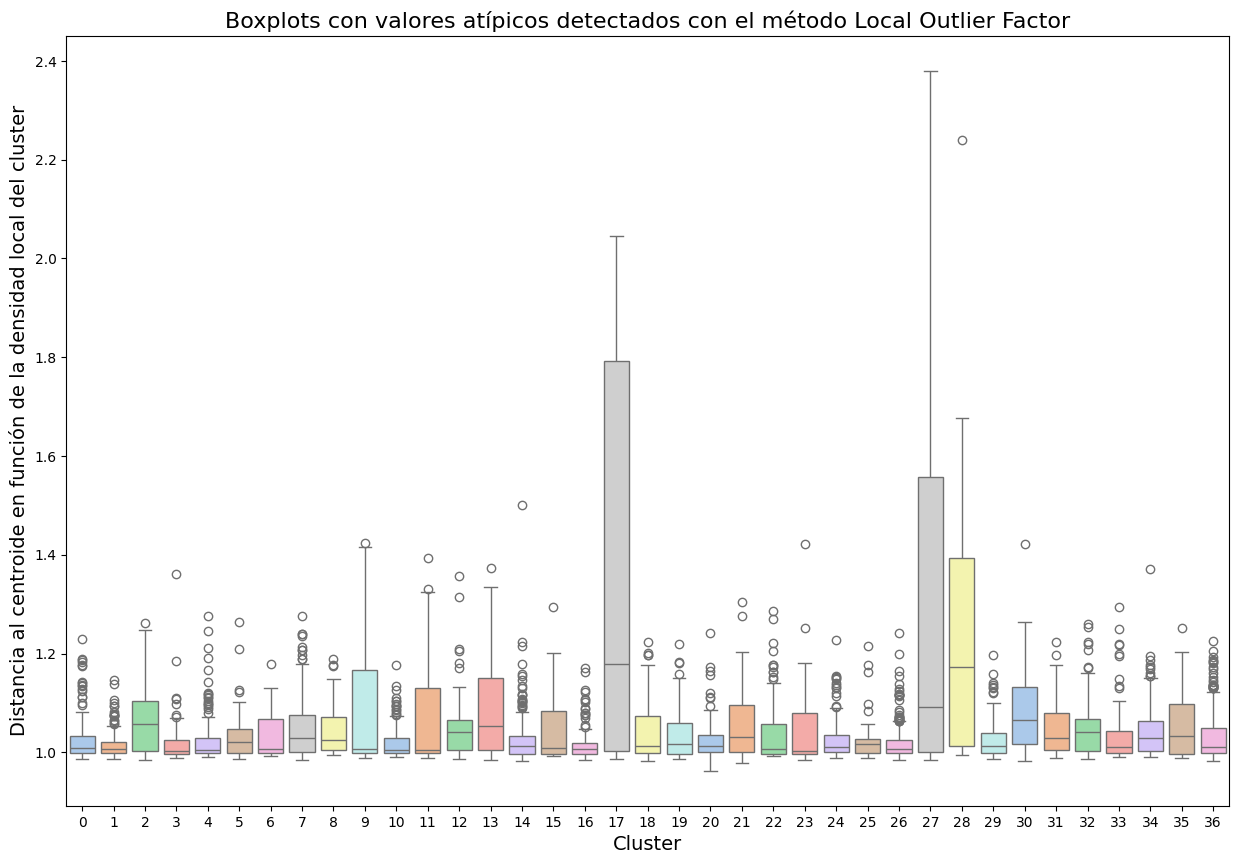

In [66]:
warnings.filterwarnings("ignore")
fig=LOF()
fig_array = fig_to_image(fig)
interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)
print(interpretation)

3) Robust covariance

https://scikit-learn.org/1.5/auto_examples/covariance/plot_robust_vs_empirical_covariance.html

https://scikit-learn.org/1.5/auto_examples/applications/plot_outlier_detection_wine.html#sphx-glr-auto-examples-applications-plot-outlier-detection-wine-py

https://scikit-learn.org/1.5/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope

In [234]:
def ROBUST_COVARIANCE():
    umap_model = umap.UMAP(n_components=3)
    umap_result = umap_model.fit_transform(np.array(embeddings_df['content_vector_norm'].tolist()))

    # Create a DataFrame with the UMAP results
    umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2', 'UMAP3'])
    umap_df['Cluster'] = embeddings_df['etiqueta_numero']  # Add cluster labels
    umap_df['Chunk_ID'] = embeddings_df['chunk_id']  # Add chunk IDs
    umap_df['Document_ID'] = embeddings_df['document_id']  # Add document IDs

    # Initialize a DataFrame to collect outlier results
    outlier_results = []

    # Perform outlier detection for each cluster
    for cluster in umap_df['Cluster'].unique():
        cluster_data = umap_df[umap_df['Cluster'] == cluster][['UMAP1', 'UMAP2', 'UMAP3']]
        
        # Fit Minimum Covariance Determinant model for outlier detection
        mcd = MinCovDet()
        mcd.fit(cluster_data)

        # Calculate Mahalanobis distances
        mahal_distances = mcd.mahalanobis(cluster_data)

        # Set a threshold to classify outliers
        threshold = np.percentile(mahal_distances, 95)  # 95th percentile as threshold for outliers
        
        # Mark outliers in the original DataFrame
        umap_df.loc[umap_df['Cluster'] == cluster, 'Outlier'] = mahal_distances > threshold

        # Collect outlier data for each cluster
        outlier_data = cluster_data[mahal_distances > threshold]
        outlier_data['Cluster'] = cluster
        outlier_data['Outlier'] = True
        outlier_results.append(outlier_data)

    # Create a grid of scatter plots
    num_clusters = len(umap_df['Cluster'].unique())
    cols = 5
    rows = (num_clusters + cols - 1) // cols  # Calculate the number of rows needed

    fig, axs = plt.subplots(rows, cols, figsize=(20, 25))
    axs = axs.flatten()  # Flatten the array of axes for easy iteration

    # Loop through each cluster to plot
    for idx, cluster in enumerate(umap_df['Cluster'].unique()):
        cluster_data = umap_df[umap_df['Cluster'] == cluster]
        
        # Plot regular data points using Seaborn
        sns.scatterplot(x='UMAP1', y='UMAP2', data=cluster_data, ax=axs[idx], alpha=0.6, hue='Cluster', palette='Set2')
        
        # Highlight outliers with red color (no label here to avoid conflict)
        if 'Outlier' in cluster_data.columns and cluster_data['Outlier'].any():
            outliers = cluster_data[cluster_data['Outlier'] == True]
            sns.scatterplot(x='UMAP1', y='UMAP2', data=outliers, ax=axs[idx], color='red', marker='x', s=100)

        axs[idx].set_title(f'Cluster: {cluster} (Outliers marked with "x")', fontsize=12)
        axs[idx].set_xlabel('UMAP Dimension 1', fontsize=10)
        axs[idx].set_ylabel('UMAP Dimension 2', fontsize=10)
        axs[idx].grid(True)

        # Remove the legend from each subplot
        axs[idx].legend([], [], frameon=False)

    # Adjust layout to prevent clipping of the legend
    plt.suptitle('Identificación de outliers aplicando la covarianza robusta', fontsize=18, y=1.02) 
    plt.tight_layout()

    return plt.gcf()


El gráfico muestra la identificación de outliers aplicando la covarianza robusta en diferentes clusters. Cada subgráfico representa un cluster específico, con los outliers marcados con una "X" roja.

### Principales tendencias y conclusiones:

1. **Distribución de Outliers**:
   - Los outliers están presentes en la mayoría de los clusters, aunque su cantidad varía significativamente entre ellos.
   - Algunos clusters, como el 0, 1, 2, 3, 5, 7, 8, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33 y 34, tienen outliers identificados.
   - Otros clusters, como el 4, 6, 9, 15, 35 y 36, no tienen outliers identificados.

2. **Patrones de Outliers**:
   - En algunos clusters, los outliers están claramente separados del grupo principal de datos, como en los clusters 0, 1, 2, 3, 5, 7, 8, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33 y 34.
   - En otros clusters, los outliers están más cerca del grupo principa

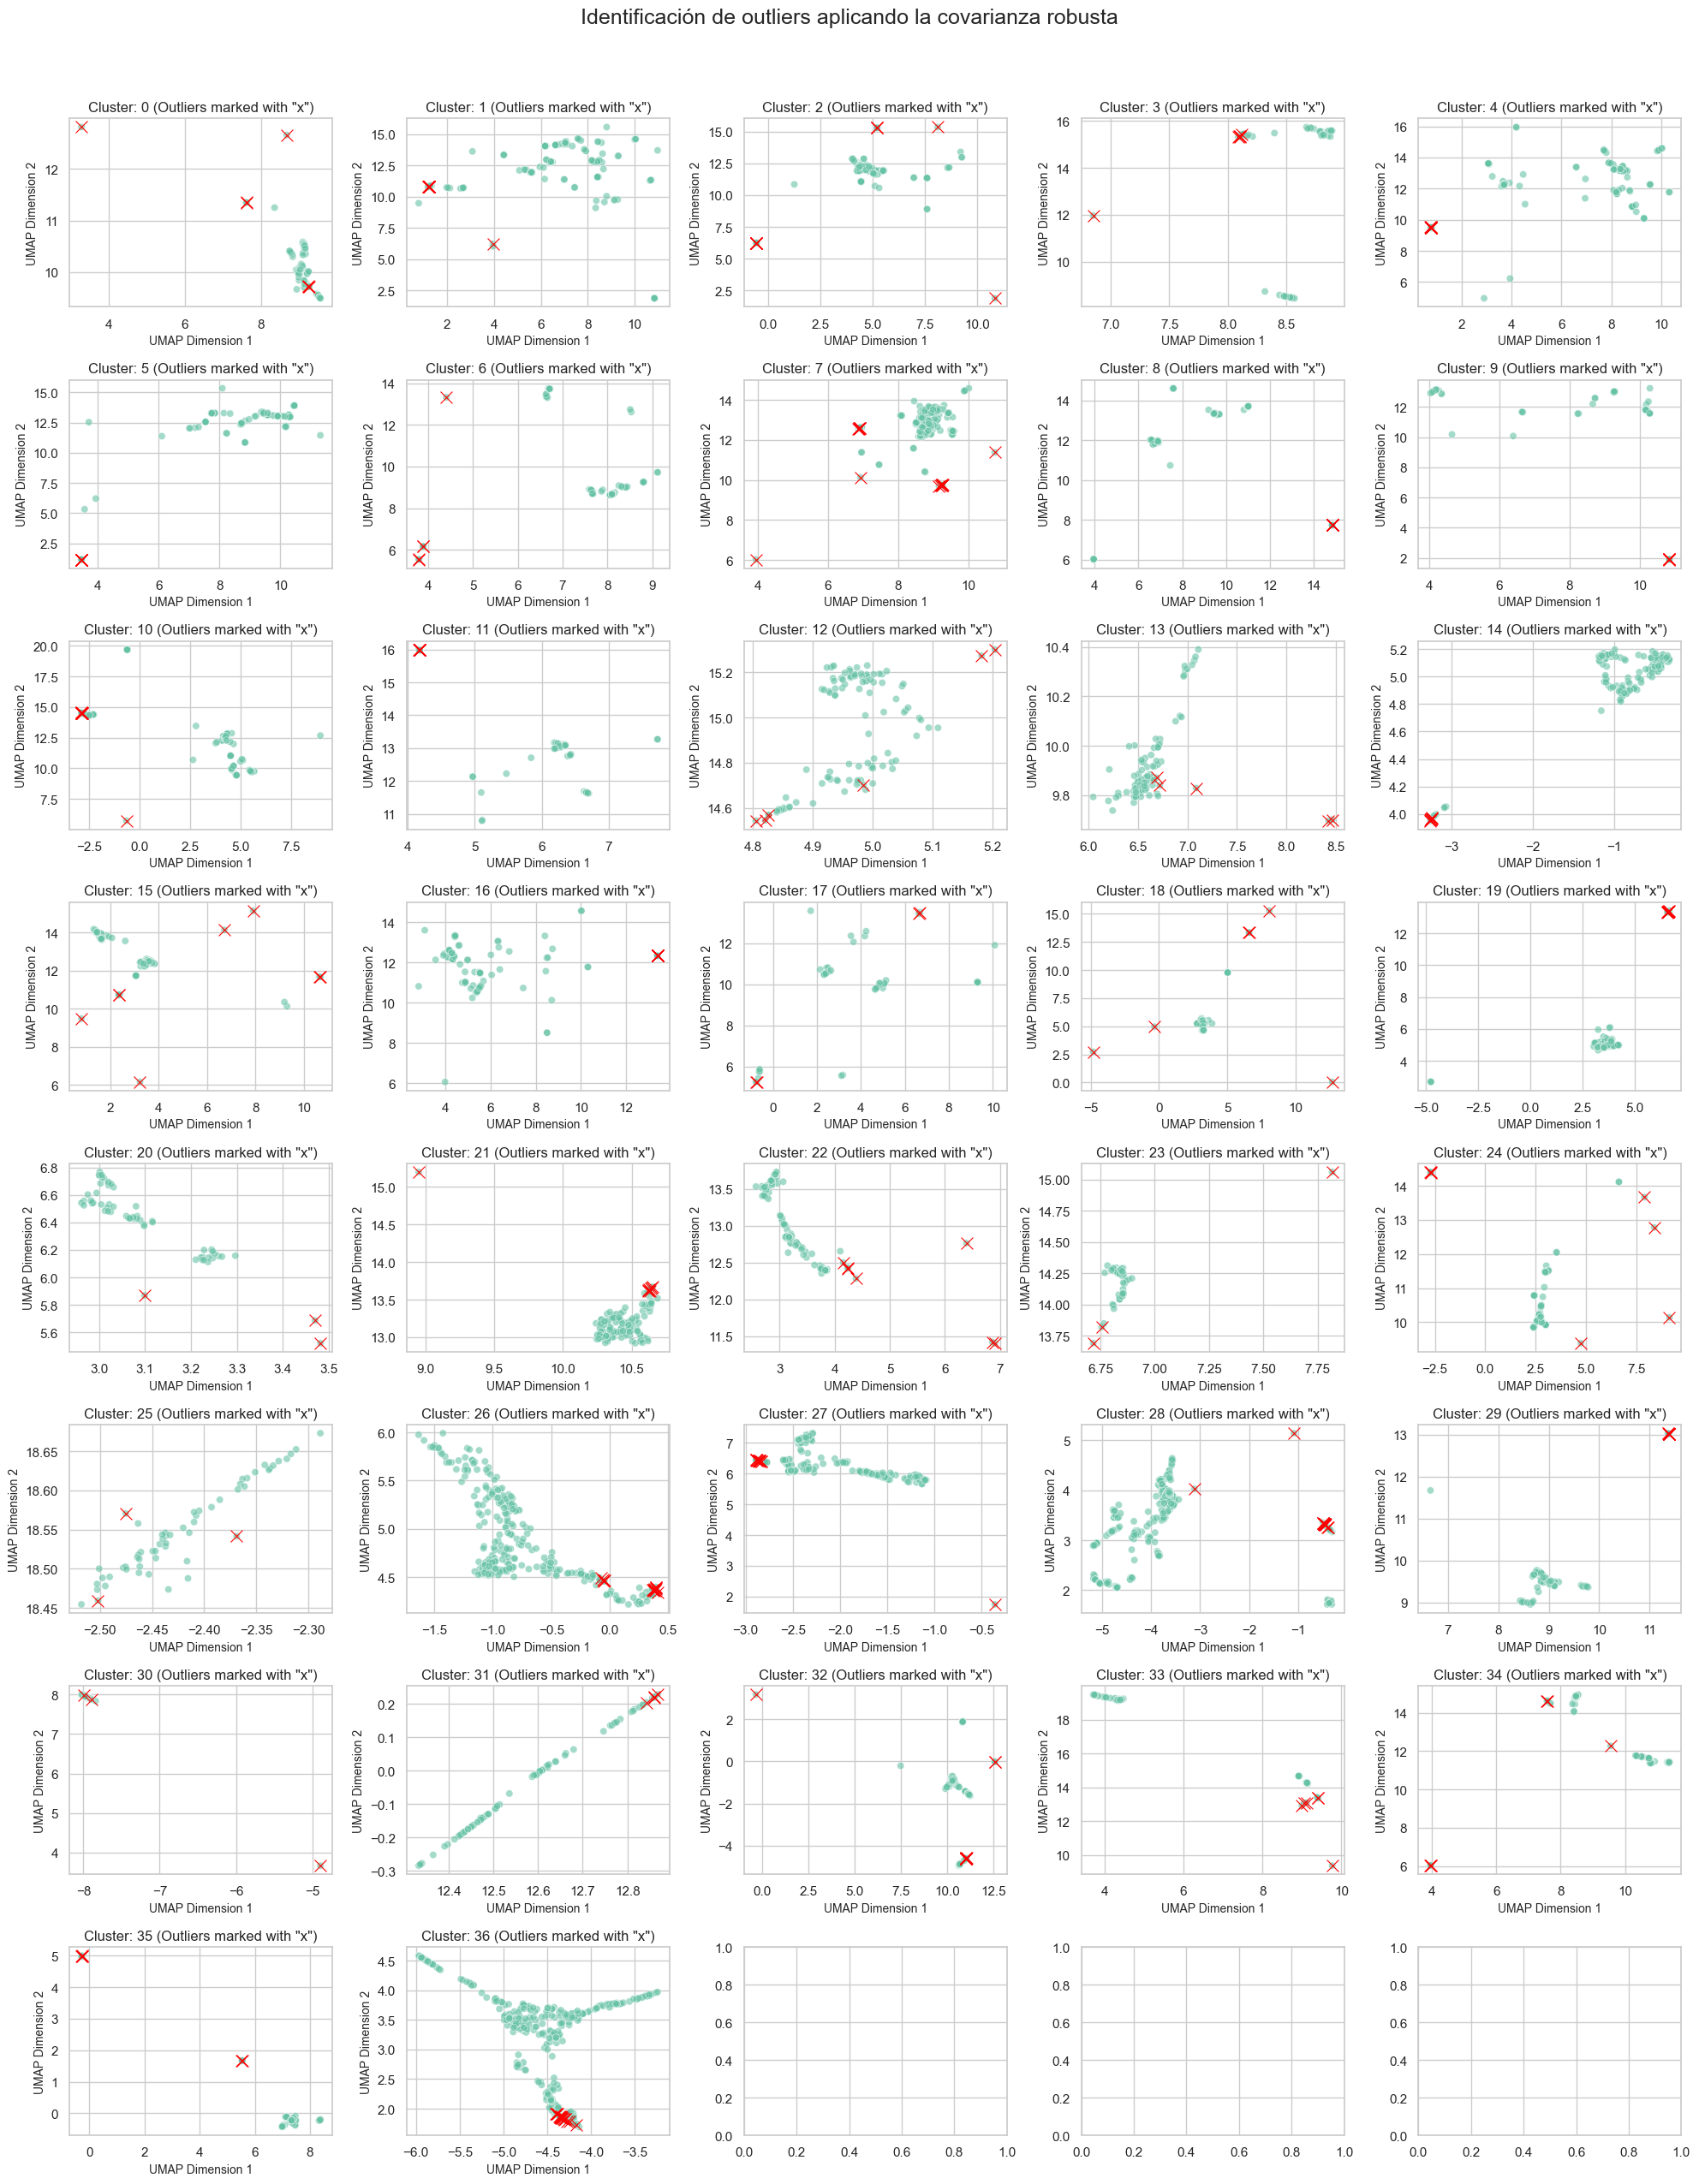

In [235]:
warnings.filterwarnings("ignore")
fig=ROBUST_COVARIANCE()
fig_array = fig_to_image(fig)
interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)
print(interpretation)